## Import

In [96]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score


## 1. Space Flights’ Mission Status SM

In [22]:
mission_status = pd.read_csv('astro_3.csv', encoding='latin-1')
mission_status.head()

id Company Launch Date Launch Time       Launch Site Vehicle Type  \
0   1  SpaceX   24-Mar-06       22:30  Marshall Islands     Falcon 1   
1   2  SpaceX   21-Mar-07        1:10  Marshall Islands     Falcon 1   
2   3  SpaceX    3-Aug-08        3:34  Marshall Islands     Falcon 1   
3   4  SpaceX    3-Aug-08        3:34  Marshall Islands     Falcon 1   
4   5  SpaceX    3-Aug-08        3:34  Marshall Islands     Falcon 1   

   Liftoff Thrust (kN)  Payload to Orbit (kg)  Rocket Height (m)  \
0                  343                    470              22.25   
1                  343                    470              22.25   
2                  343                    470              22.25   
3                  343                    470              22.25   
4                  343                    470              22.25   

   Fairing Diameter (m)  ... weathercode snowfall soil_moisture_0_to_7cm  \
0                   1.5  ...           1        0                    0.0   
1                   1.5  ...           0        0                    0.0   
2                   1.5  ...           2        0                    0.0   
3                   1.5  ...           2        0                    0.0   
4                   1.5  ...           2        0                    0.0   

  soil_moisture_7_to_28cm soil_moisture_28_to_100cm  \
0                     0.0                       0.0   
1                     0.0                       0.0   
2                     0.0                       0.0   
3                     0.0                       0.0   
4                     0.0                       0.0   

  soil_moisture_100_to_255cm  soil_temperature_0_to_7cm  \
0                        0.0                       28.3   
1                        0.0                       28.8   
2                        0.0                       28.1   
3                        0.0                       28.1   
4                        0.0                       28.1   

   soil_temperature_7_to_28cm  soil_temperature_28_to_100cm  \
0                        28.3                          28.3   
1                        28.8                          28.8   
2                        28.1                          28.1   
3                        28.1                          28.1   
4                        28.1                          28.1   

  soil_temperature_100_to_255cm  
0                          28.3  
1                          28.8  
2                          28.1  
3                          28.1  
4                          28.1  

[5 rows x 50 columns]

Payload type

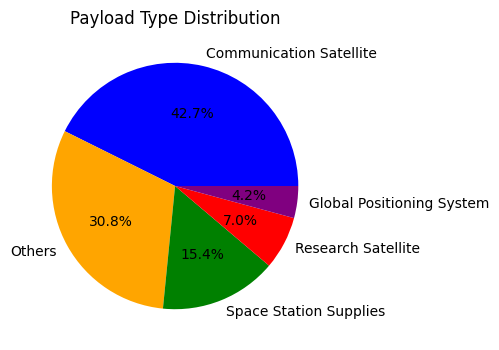

In [23]:
payload_counts = mission_status['Payload Type'].value_counts()

threshold = 0.03 * len(mission_status)
small_categories = payload_counts[payload_counts < threshold].index
mission_status['Payload Type'] = mission_status['Payload Type'].apply(lambda x: 'Others' if x in small_categories else x)

payload_counts = mission_status['Payload Type'].value_counts()

colors_for_all_status = ['blue', 'orange', 'green', 'red', 'purple']  

plt.figure(figsize=(4, 4))
plt.pie(payload_counts, labels=payload_counts.index, autopct='%1.1f%%', colors=colors_for_all_status)
plt.title('Payload Type Distribution')
plt.show()

## 1.1 Success and failure

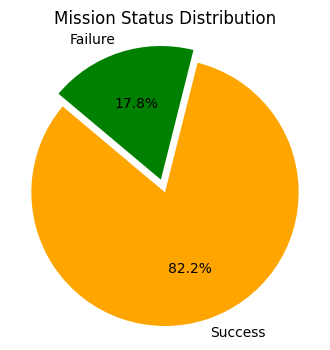

In [24]:
success_data = mission_status[mission_status["Mission Status"] == "Success"]
failure_data = mission_status[mission_status["Mission Status"] == "Failure"]

success_count = len(success_data)
failure_count = len(failure_data)

labels = ["Success", "Failure"]
sizes = [success_count, failure_count]

explode = (0, 0.1) 

colors_for_all_status = ['orange', 'green']  
plt.figure(figsize=(4, 4))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140,  colors=colors_for_all_status)
plt.axis('equal')
plt.title("Mission Status Distribution")
plt.show()

Success and failure as the year

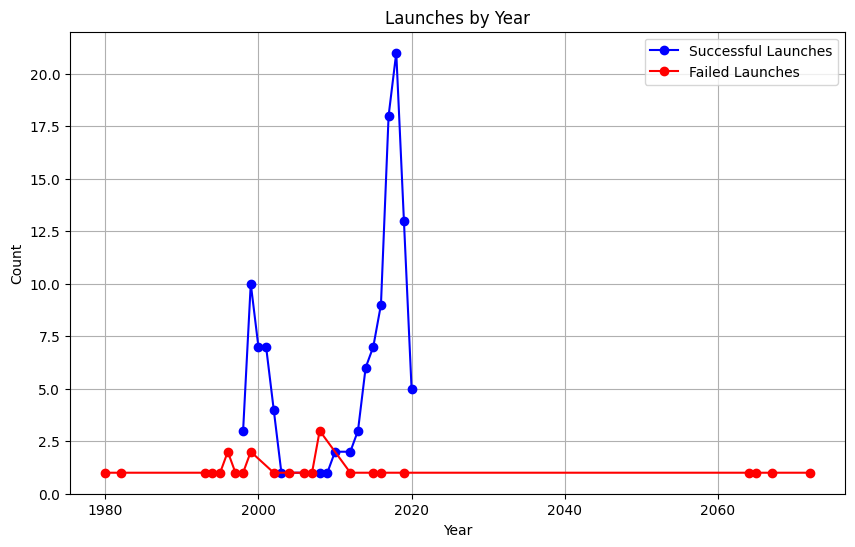

In [25]:
success_data['Launch Date'] = pd.to_datetime(success_data['Launch Date'])
failure_data['Launch Date'] = pd.to_datetime(failure_data['Launch Date'])

success_by_year = success_data.groupby(success_data['Launch Date'].dt.year).size()
failure_by_year = failure_data.groupby(failure_data['Launch Date'].dt.year).size()

plt.figure(figsize=(10, 6))
plt.plot(success_by_year.index, success_by_year.values, marker='o', linestyle='-', color='blue', label='Successful Launches')
plt.plot(failure_by_year.index, failure_by_year.values, marker='o', linestyle='-', color='red', label='Failed Launches')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Launches by Year')
plt.legend()
plt.grid(True)
plt.show()

## 1.2 Number of launches

Number of launches by month

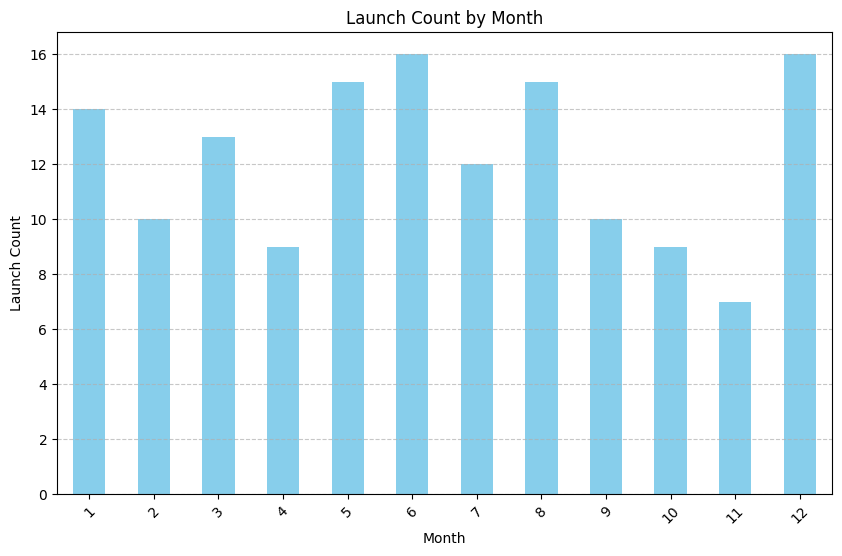

In [26]:
mission_status['Launch Date'] = pd.to_datetime(mission_status['Launch Date'])

monthly_launch_count = mission_status.groupby(mission_status['Launch Date'].dt.month).size()

plt.figure(figsize=(10, 6))
monthly_launch_count.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Launch Count')
plt.title('Launch Count by Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Failure number of of launches by month

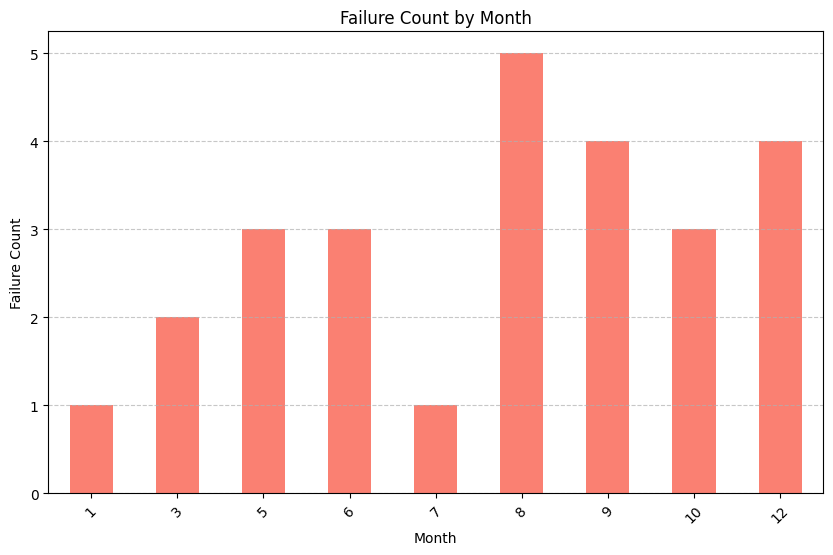

In [27]:
failure_data = mission_status[mission_status["Mission Status"] == "Failure"]

monthly_failure_count = failure_data.groupby(failure_data['Launch Date'].dt.month).size()

plt.figure(figsize=(10, 6))
monthly_failure_count.plot(kind='bar', color='salmon')
plt.xlabel('Month')
plt.ylabel('Failure Count')
plt.title('Failure Count by Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 1.3 K-means for failure lunches features

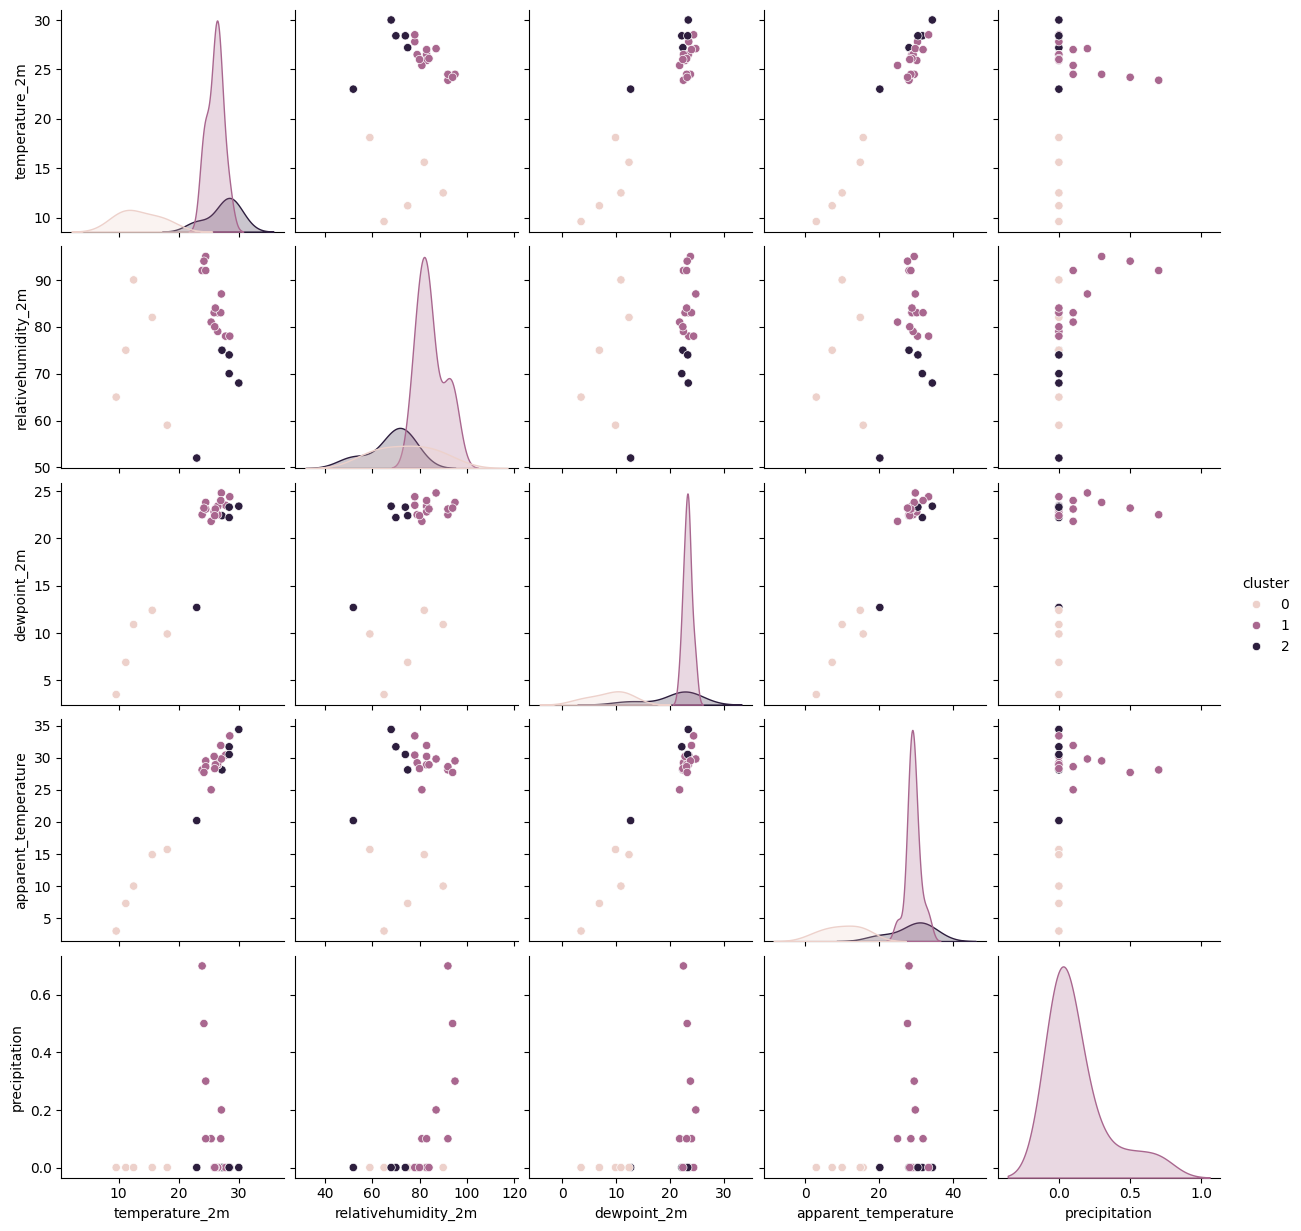

In [84]:
failure_data = mission_status[mission_status["Mission Status"] == "Failure"]
# Atmospheric conditions
features1 = ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature', 'precipitation']
#['temperature_2m', 'relativehumidity_2m', 'windspeed_10m', 'precipitation', 'cloudcover']

X = failure_data[features1]
X = X.select_dtypes(include=np.number)
kmeans = KMeans(n_clusters=3, random_state=42)
failure_data['cluster'] = kmeans.fit_predict(X)

sns.pairplot(data=failure_data, hue='cluster', vars=features1, diag_kind='kde')
plt.show()

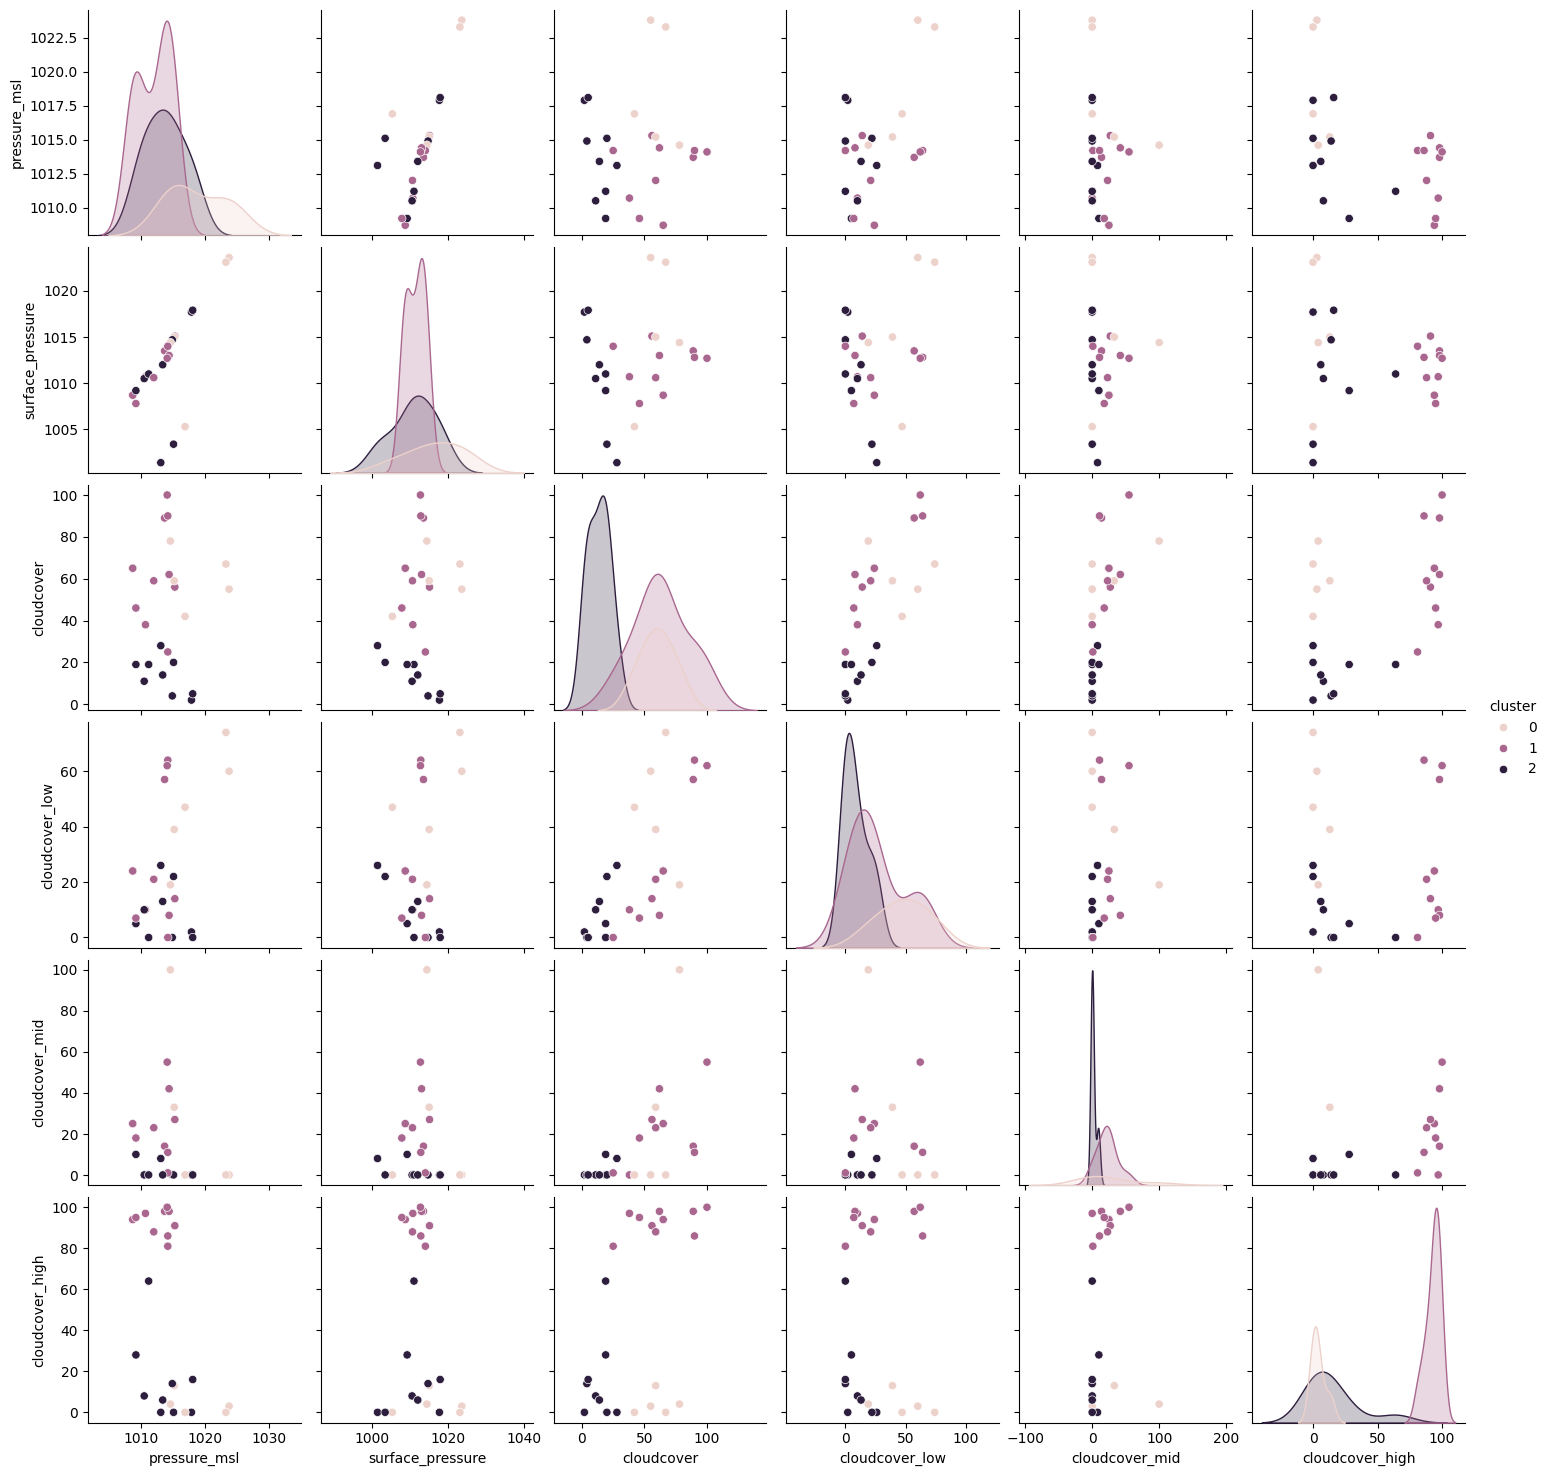

In [85]:
# Pressure and cloud cover
features2 = ['pressure_msl', 'surface_pressure', 'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high']
#['pressure_msl', 'surface_pressure', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high']

X = failure_data[features2]

kmeans = KMeans(n_clusters=3, random_state=42)
failure_data['cluster'] = kmeans.fit_predict(X)

sns.pairplot(data=failure_data, hue='cluster', vars=features2, diag_kind='kde')
plt.show()

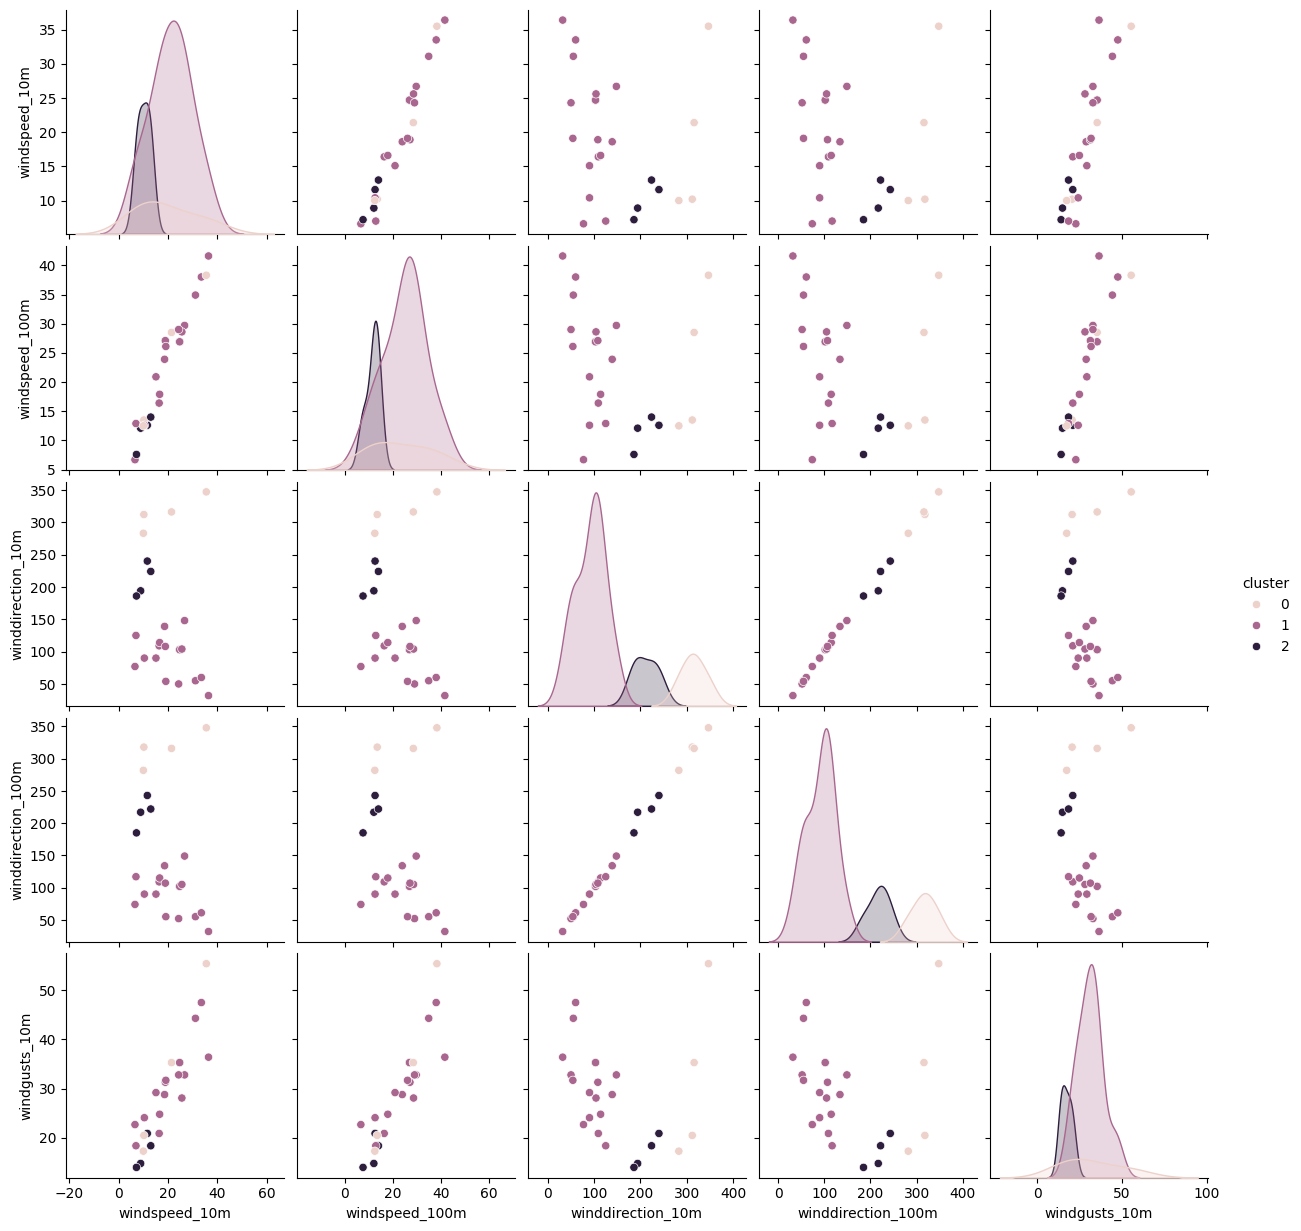

In [86]:
# Wind conditions
features3 = ['windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m', 'windgusts_10m']
# ['windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m', 'windgusts_10m']

X = failure_data[features3]

kmeans = KMeans(n_clusters=3, random_state=42)
failure_data['cluster'] = kmeans.fit_predict(X)

sns.pairplot(data=failure_data, hue='cluster', vars=features3, diag_kind='kde')
plt.show()

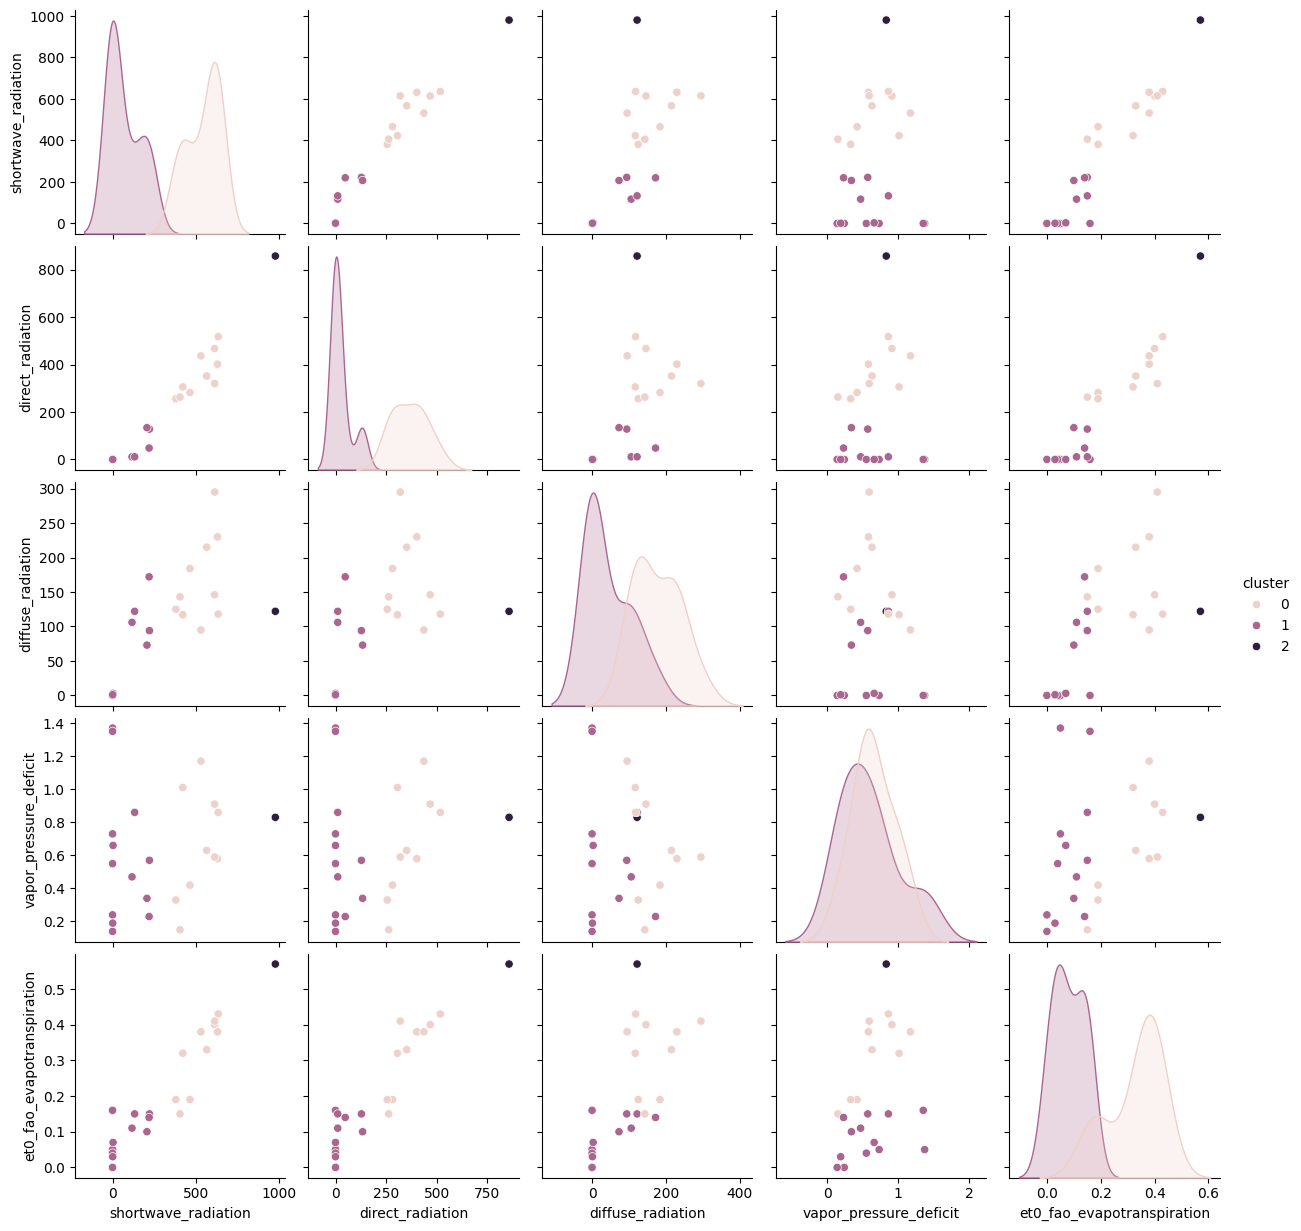

In [87]:
# Radiation and evapotranspiration
features4 = ['shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'vapor_pressure_deficit', 'et0_fao_evapotranspiration']
#['shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'vapor_pressure_deficit', 'et0_fao_evapotranspiration']

X = failure_data[features4]

kmeans = KMeans(n_clusters=3, random_state=42)
failure_data['cluster'] = kmeans.fit_predict(X)

sns.pairplot(data=failure_data, hue='cluster', vars=features4, diag_kind='kde')
plt.show()

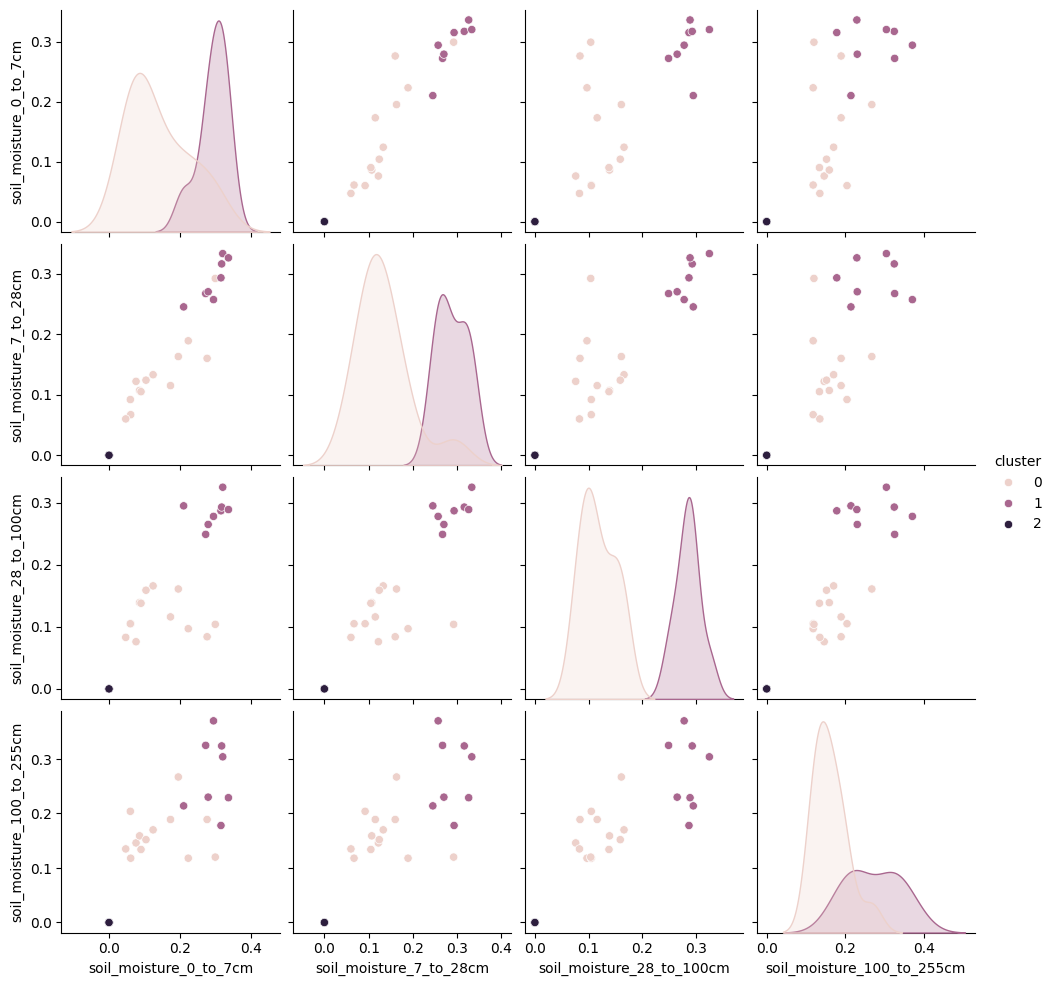

In [88]:
features5 = ['soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm','soil_moisture_100_to_255cm']
#['soil_moisture_100_to_255cm', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm']
X = failure_data[features5]

kmeans = KMeans(n_clusters=3, random_state=42)
failure_data['cluster'] = kmeans.fit_predict(X)

sns.pairplot(data=failure_data, hue='cluster', vars=features5, diag_kind='kde')
plt.show()

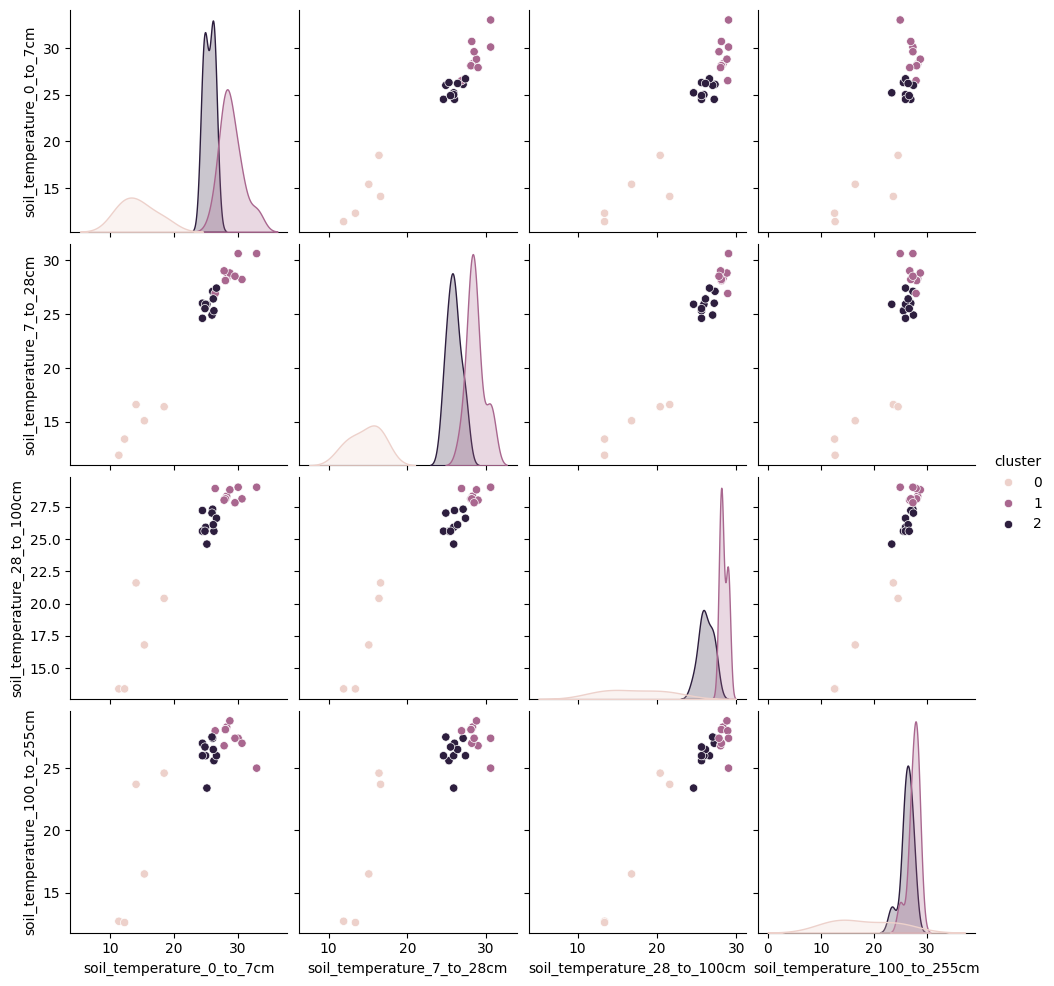

In [89]:
features6 = ['soil_temperature_0_to_7cm','soil_temperature_7_to_28cm','soil_temperature_28_to_100cm','soil_temperature_100_to_255cm']
X = failure_data[features6]

kmeans = KMeans(n_clusters=3, random_state=42)
failure_data['cluster'] = kmeans.fit_predict(X)

sns.pairplot(data=failure_data, hue='cluster', vars=features6, diag_kind='kde')
plt.show()

# Influence of features on the outcomes of mission

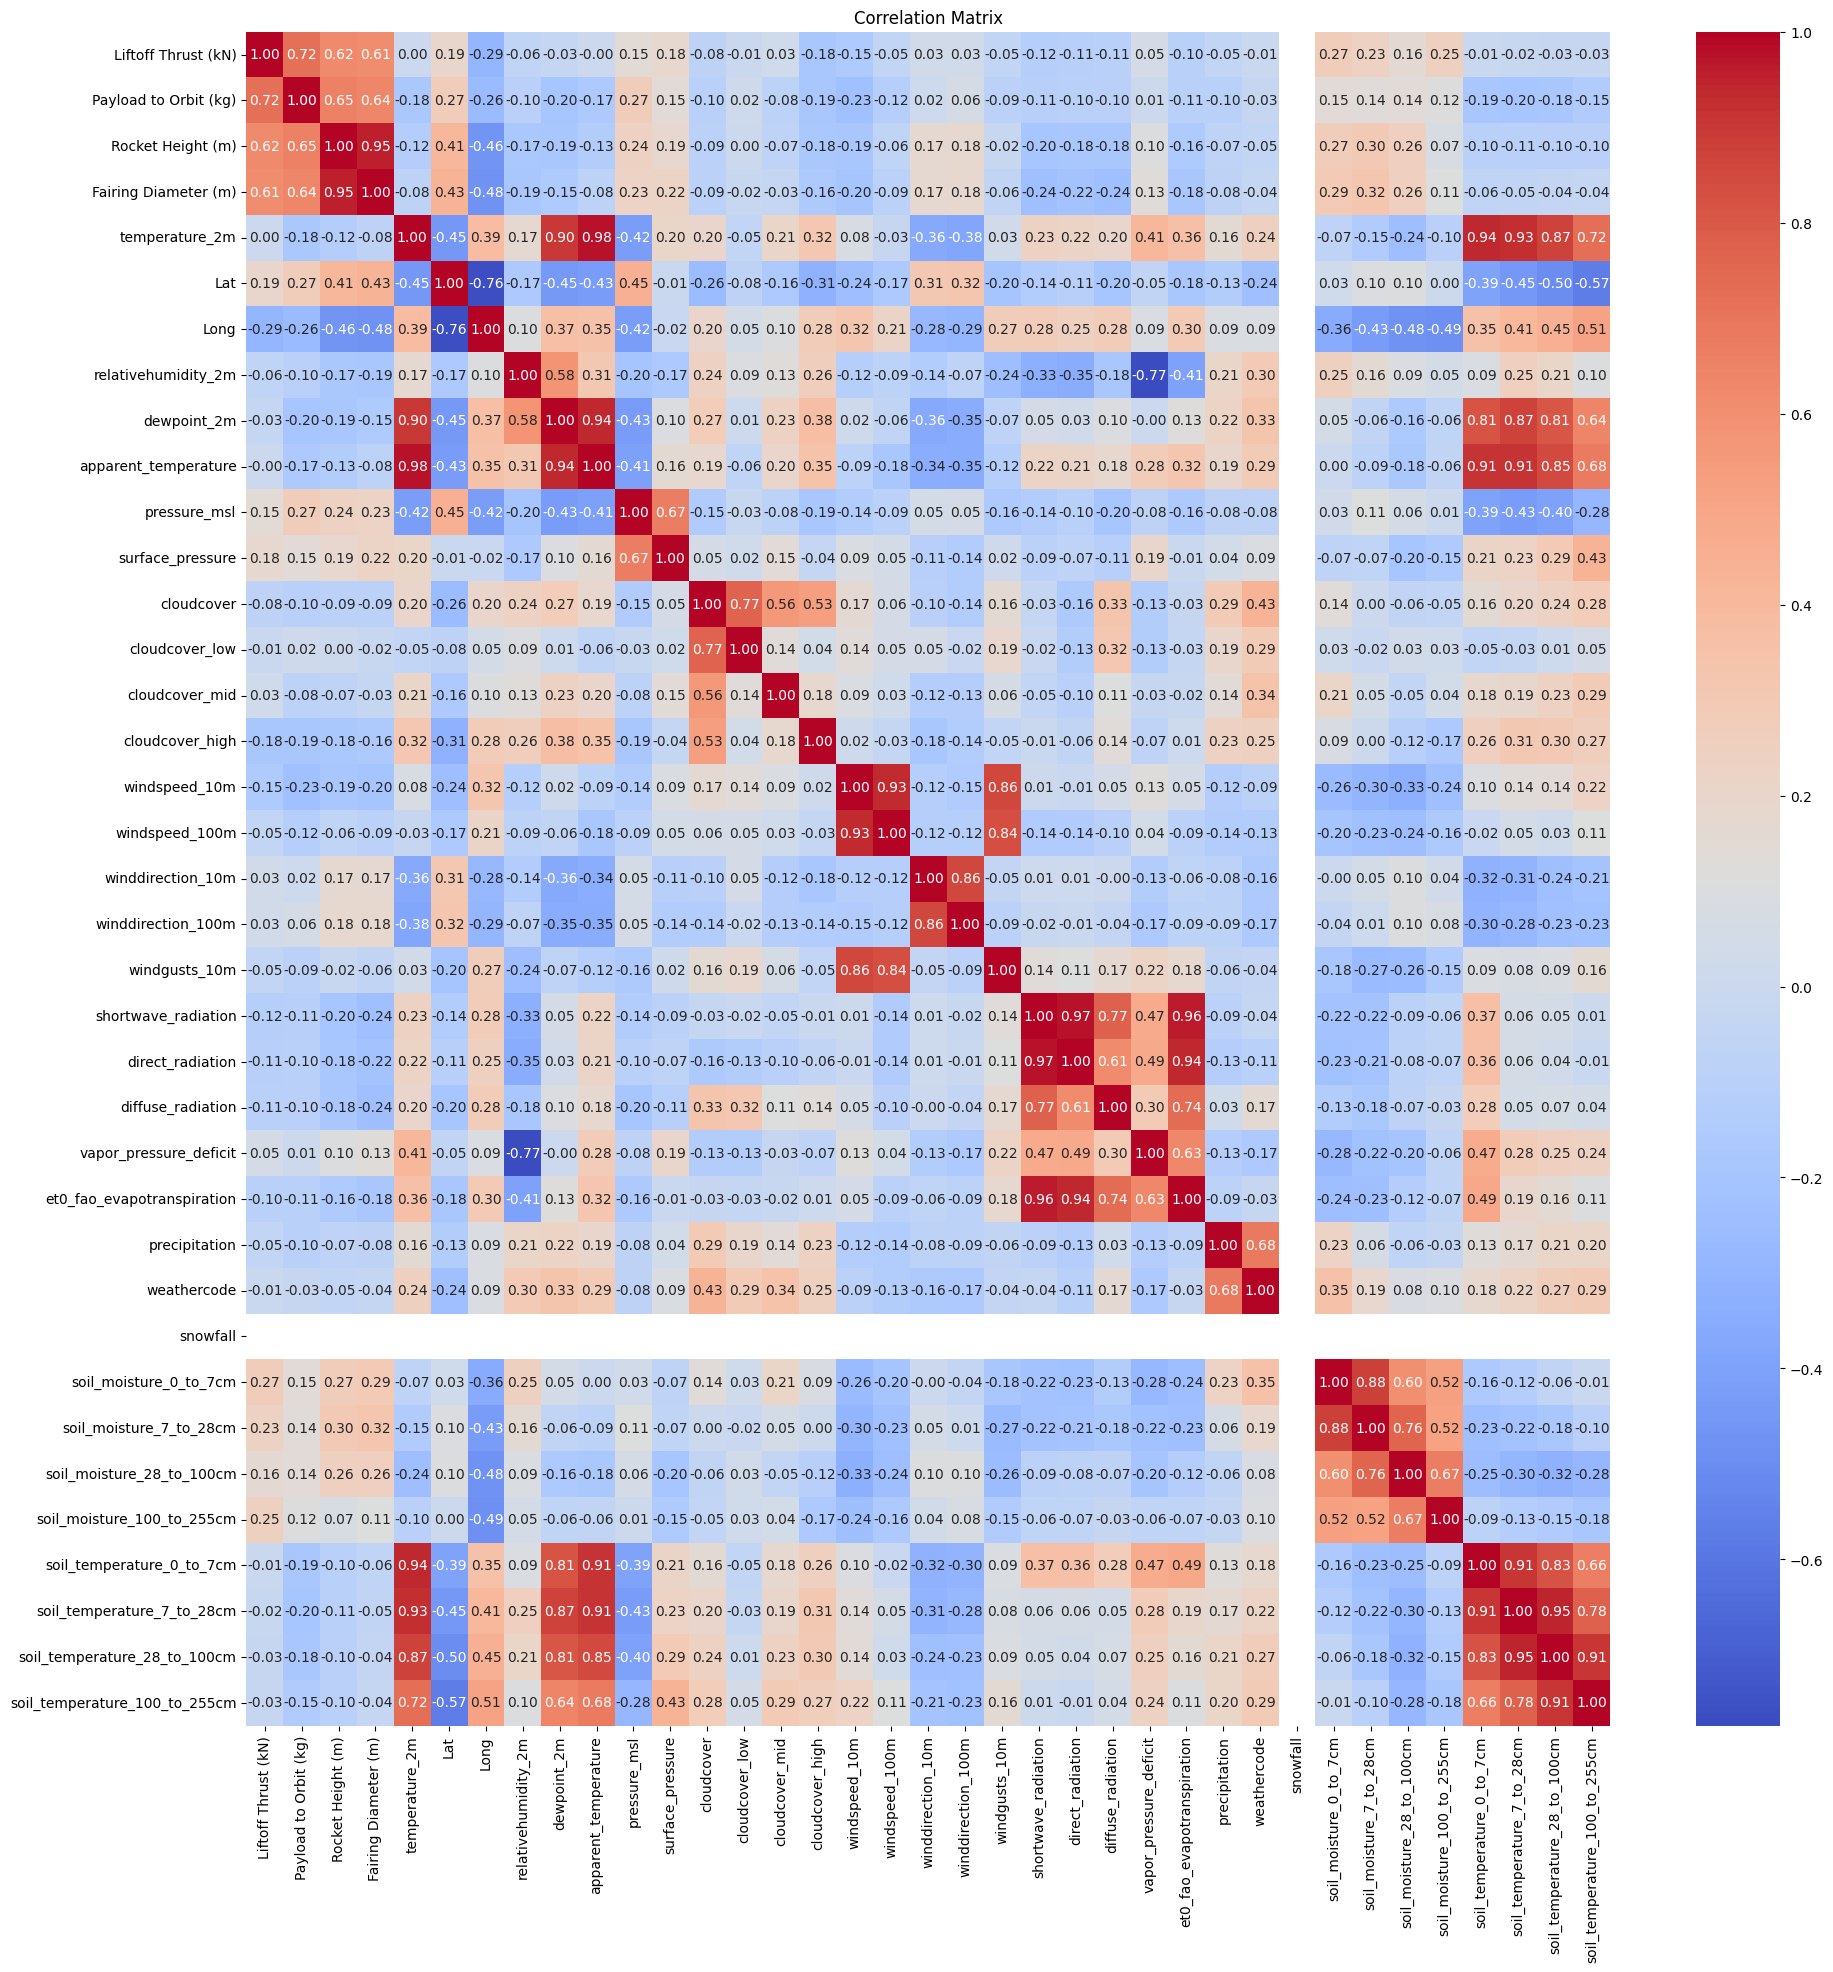

In [40]:
data = pd.read_csv('astro_3.csv', encoding='latin-1')
numerical_data = data.select_dtypes(include=np.number)
numerical_data = numerical_data.drop('id', axis=1)
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(22,22))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [100]:
X = data.drop('id', axis=1)
X = X.drop('Mission Status', axis=1)
X = X.select_dtypes(include=np.number)
y = data['Mission Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Prediction of outcomes

In [93]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8666666666666667


In [77]:
feature_importance = rf_classifier.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]
# Print feature importance
print("Feature Importance:")
for i, idx in enumerate(sorted_indices):
    print(f"{i+1}. {X.columns[idx]}: {feature_importance[idx]}")

Feature Importance:
1. Liftoff Thrust (kN): 0.11851649918157489
2. Fairing Diameter (m): 0.08383510086840167
3. Long: 0.07472812389288237
4. Lat: 0.07419567449489119
5. Rocket Height (m): 0.07179039372606069
6. soil_temperature_100_to_255cm: 0.04621754472795099
7. pressure_msl: 0.04329747141498343
8. soil_moisture_0_to_7cm: 0.040592864750110515
9. Payload to Orbit (kg): 0.03391538131925133
10. soil_moisture_100_to_255cm: 0.029530694725923113
11. soil_moisture_7_to_28cm: 0.02780125789814597
12. surface_pressure: 0.027488115212231785
13. windspeed_10m: 0.025843403562008177
14. temperature_2m: 0.02375953043644805
15. soil_moisture_28_to_100cm: 0.020641734042315514
16. dewpoint_2m: 0.018572678990061
17. cloudcover_low: 0.017218713328901725
18. precipitation: 0.016223534816534272
19. cloudcover: 0.01594675930303947
20. apparent_temperature: 0.015802479939135458
21. soil_temperature_7_to_28cm: 0.015797945803069712
22. weathercode: 0.01530969238152292
23. winddirection_10m: 0.0150598698277093

In [78]:
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.9        0.82758621 0.82758621 0.89655172 0.65517241]
Mean CV Score: 0.8213793103448277



Permutation Importance:
1. Liftoff Thrust (kN): 0.06222222222222221
2. pressure_msl: 0.05333333333333332
3. soil_moisture_28_to_100cm: 0.0511111111111111
4. soil_moisture_100_to_255cm: 0.046666666666666655
5. soil_temperature_28_to_100cm: 0.03555555555555555
6. soil_temperature_100_to_255cm: 0.033333333333333326
7. Rocket Height (m): 0.031111111111111103
8. surface_pressure: 0.031111111111111103
9. soil_moisture_7_to_28cm: 0.0
10. cloudcover_mid: 0.0
11. Payload to Orbit (kg): 0.0
12. Fairing Diameter (m): 0.0
13. temperature_2m: 0.0
14. Lat: 0.0
15. Long: 0.0
16. relativehumidity_2m: 0.0
17. dewpoint_2m: 0.0
18. apparent_temperature: 0.0
19. soil_temperature_7_to_28cm: 0.0
20. cloudcover: 0.0
21. cloudcover_low: 0.0
22. cloudcover_high: 0.0
23. soil_moisture_0_to_7cm: 0.0
24. windspeed_10m: 0.0
25. windspeed_100m: 0.0
26. soil_temperature_0_to_7cm: 0.0
27. winddirection_100m: 0.0
28. windgusts_10m: 0.0
29. shortwave_radiation: 0.0
30. direct_radiation: 0.0
31. diffuse_radiation: 0.0


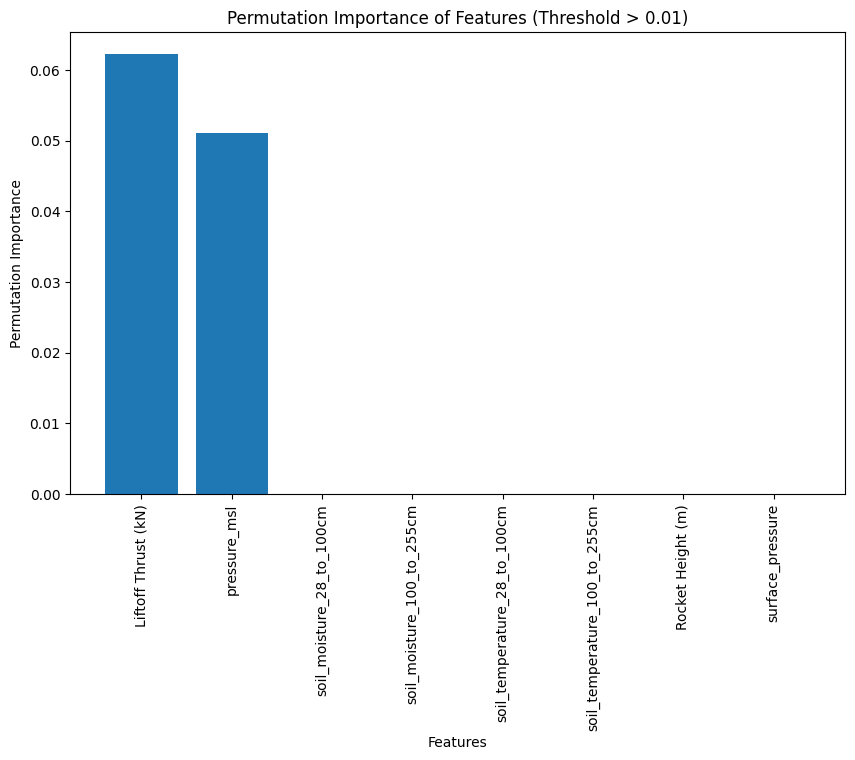

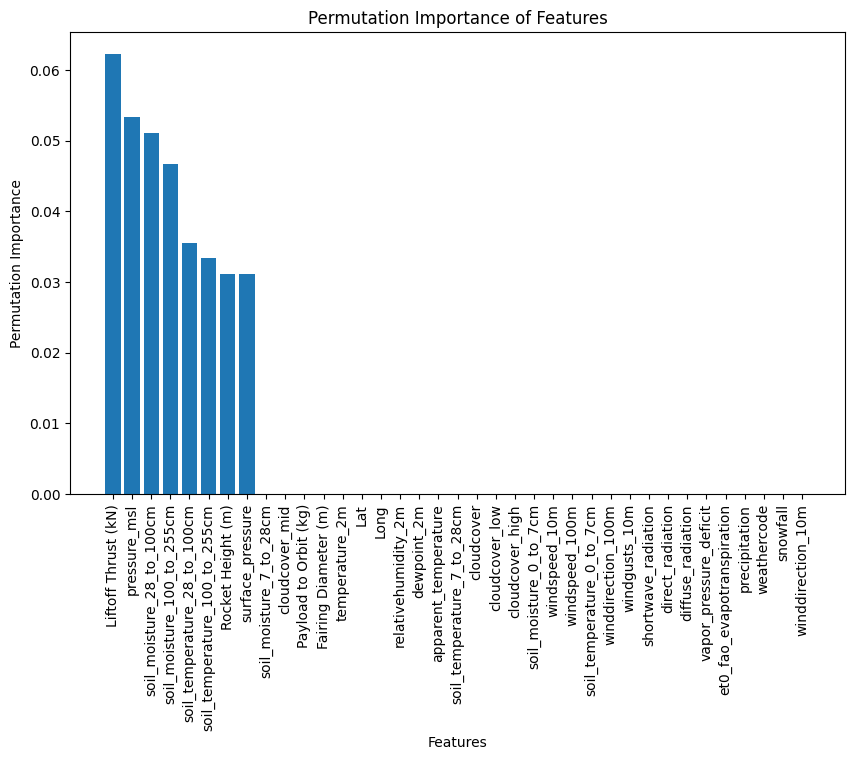

In [79]:
perm_importance = permutation_importance(rf_classifier, X_test, y_test, n_repeats=30, random_state=42)
sorted_indices_perm = np.argsort(perm_importance.importances_mean)[::-1]
# Print permutation importance
print("\nPermutation Importance:")
for i, idx in enumerate(sorted_indices_perm):
    print(f"{i+1}. {X.columns[idx]}: {perm_importance.importances_mean[idx]}")

threshold = 0.01  
plt.figure(figsize=(10, 6))
plt.bar([X.columns[idx] for idx in sorted_indices_perm if perm_importance.importances_mean[idx] > threshold], 
        perm_importance.importances_mean[sorted_indices_perm][perm_importance.importances_mean > threshold])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance of Features (Threshold > 0.01)')
plt.show()
# Visualization of permutation importance
plt.figure(figsize=(10, 6))
plt.bar([X.columns[idx] for idx in sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

In [103]:
# Check unique classes in the target variable
unique_classes = y_train.unique()
print("Unique classes in y_train:", unique_classes)


Unique classes in y_train: ['Failure']


In [115]:
df = pd.read_csv('astro_3.csv', encoding='latin-1')
df_cleaned = df.dropna(axis=1)
X = df_cleaned.drop('id', axis=1)
X = X.drop('Mission Status', axis=1)
y = df_cleaned['Mission Status']
X = X.select_dtypes(include=np.number)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Create Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the model
gb_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = gb_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.875


In [118]:
gb_classifier.fit(X_train, y_train)

# Obtain feature importances
feature_importance = gb_classifier.feature_importances_

sorted_feature_importance = np.argsort(feature_importance)[::-1]
# Print feature importance
print("Feature Importance:")
for i, idx in enumerate(sorted_feature_importance):
    print(f"{i+1}. {X.columns[idx]}: {feature_importance[idx]}")



Feature Importance:
1. Liftoff Thrust (kN): 0.45198852388197946
2. Long: 0.07222659089897775
3. Lat: 0.06860516924288385
4. soil_temperature_100_to_255cm: 0.050559989660377676
5. Rocket Height (m): 0.04929841439286642
6. soil_moisture_0_to_7cm: 0.04806258699731819
7. dewpoint_2m: 0.03730289093139718
8. precipitation: 0.031025490739325427
9. cloudcover_mid: 0.027485344294353082
10. cloudcover: 0.026918963530872874
11. apparent_temperature: 0.022281212797010758
12. windgusts_10m: 0.021702876796137086
13. soil_temperature_7_to_28cm: 0.017822346280252872
14. soil_moisture_100_to_255cm: 0.013333263692500407
15. windspeed_10m: 0.012008942284676869
16. temperature_2m: 0.007671819951961825
17. soil_moisture_7_to_28cm: 0.006357271494695237
18. soil_temperature_28_to_100cm: 0.006164634390058653
19. windspeed_100m: 0.005666444470983283
20. pressure_msl: 0.0043933148505772126
21. shortwave_radiation: 0.003155187294270022
22. soil_temperature_0_to_7cm: 0.0030873561133650494
23. surface_pressure: 0.

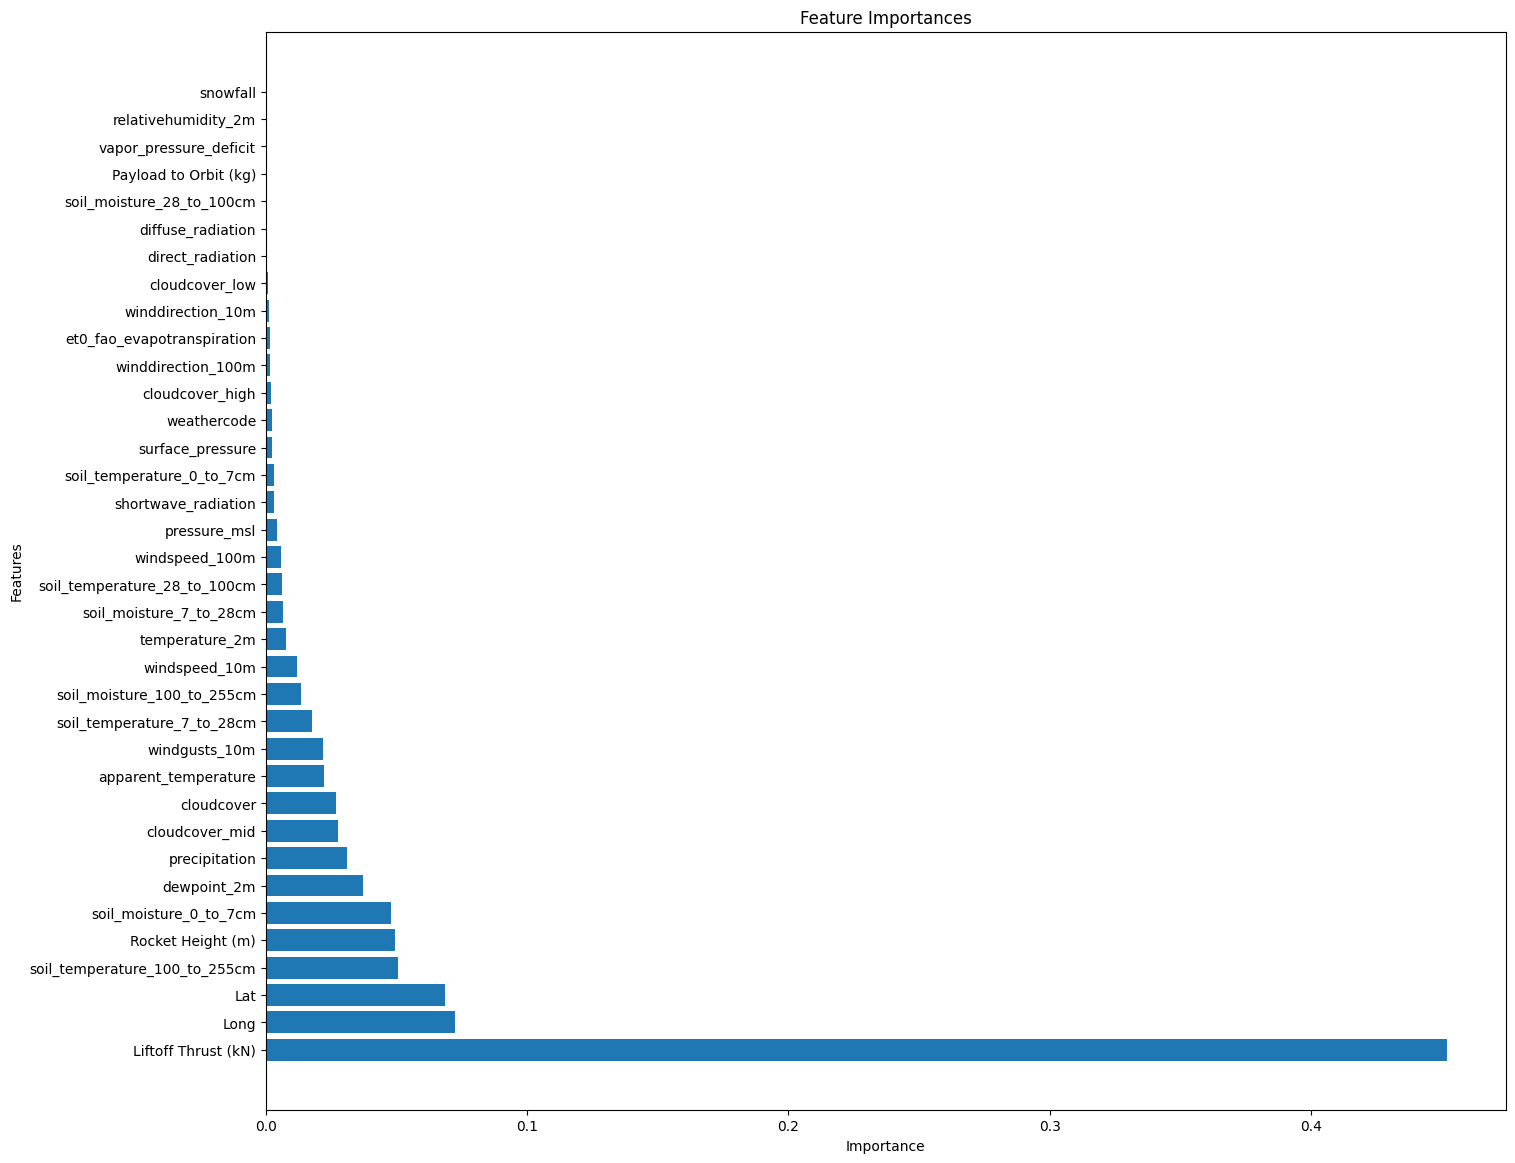

In [129]:
sorted_feature_names = X.columns[sorted_feature_importance]

# Plot the feature importances
plt.figure(figsize=(16, 14))
plt.barh(range(len(sorted_feature_names)), feature_importance[sorted_feature_importance], align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

## 2.  All Space Missions from 1957 SC

In [4]:
#space_mission = pd.read_csv('astro_3.csv', encoding='latin-1') # why is it astro_3.csv
space_mission = pd.read_csv('Space_Corrected.csv', encoding='latin-1')
space_mission.head()

id Company Name                                           Location  \
0   1       SpaceX         LC-39A, Kennedy Space Center, Florida, USA   
1   2         CASC  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2   3       SpaceX                      Pad A, Boca Chica, Texas, USA   
3   4    Roscosmos       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4   5          ULA           SLC-41, Cape Canaveral AFS, Florida, USA   

                        Datum                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   
2  Tue Aug 04, 2020 23:57 UTC            Starship Prototype | 150 Meter Hop   
3  Thu Jul 30, 2020 21:25 UTC  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4  Thu Jul 30, 2020 11:50 UTC                    Atlas V 541 | Perseverance   

  Status Rocket Rocket Status Mission  
0  StatusActive     50        Success  
1  StatusActive  29.75        Success  
2  StatusActive    NaN        Success  
3  StatusActive     65        Success  
4  StatusActive    145        Success

## 2.1 Number of launches

Countries with more than 15 launches

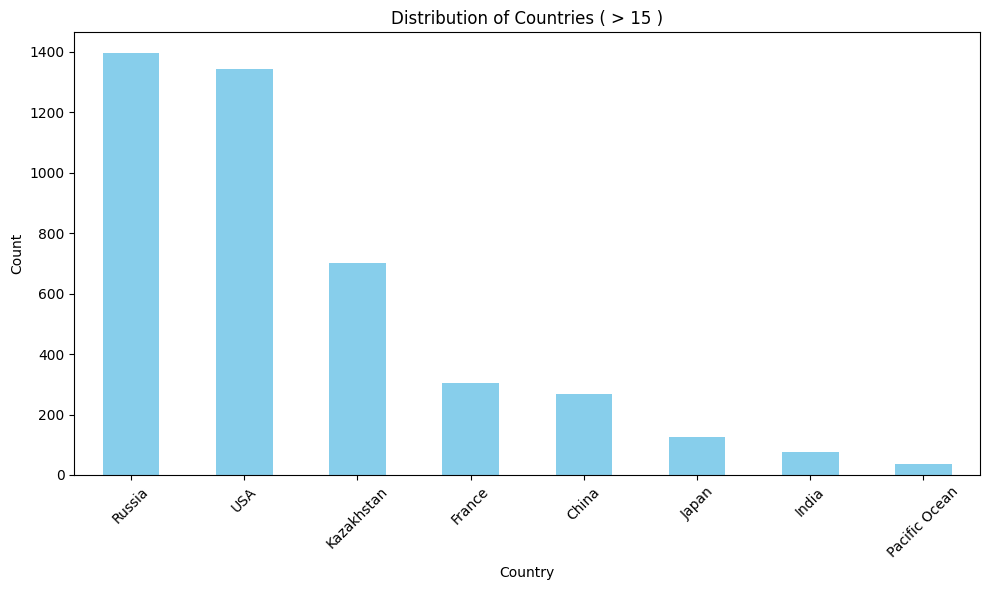

In [5]:
space_mission['Country'] = space_mission['Location'].apply(lambda x: x.split(',')[-1].strip())

country_counts = space_mission['Country'].value_counts()

threshold = 15
country_counts = country_counts[country_counts > threshold]

plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Countries ( > 15 )')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Countries with more than 15 launches as the year

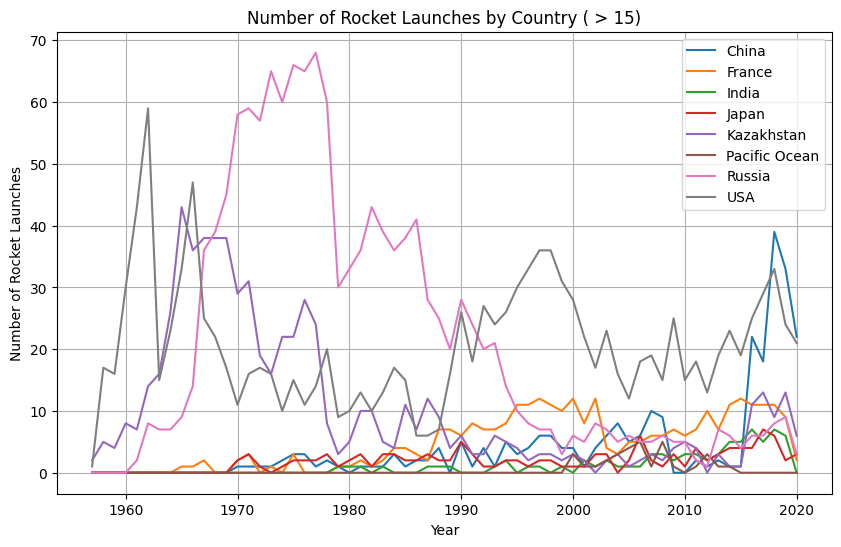

In [6]:
space_mission["Datum"] = pd.to_datetime(space_mission["Datum"],errors="coerce", utc=True)
space_mission["year"] = space_mission["Datum"].dt.year

country_counts = country_counts[country_counts > threshold]

space_mission['Country'] = space_mission['Location'].apply(lambda x: x.split(',')[-1].strip())

filtered_space_mission = space_mission[space_mission['Country'].isin(country_counts.index)]

country_year_counts = filtered_space_mission.groupby(['Country', 'year']).size().unstack().fillna(0)

plt.figure(figsize=(10, 6))

for country in country_year_counts.index:
    plt.plot(country_year_counts.loc[country], label=country)

plt.title('Number of Rocket Launches by Country ( > 15)')
plt.xlabel('Year')
plt.ylabel('Number of Rocket Launches')
plt.legend()
plt.grid(True)
plt.show()

Total launches as the year

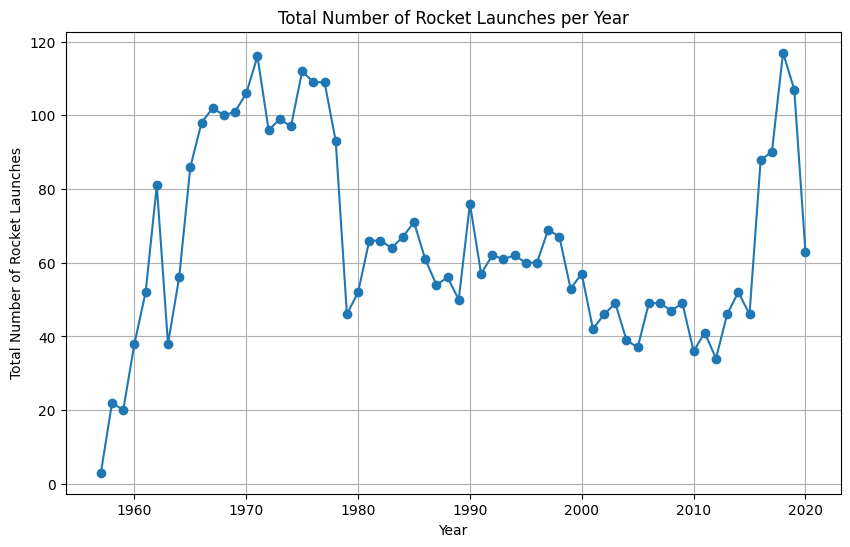

In [7]:
launch_counts = space_mission.groupby('year').size()

plt.figure(figsize=(10, 6))
plt.plot(launch_counts.index, launch_counts.values, marker='o', linestyle='-')
plt.title('Total Number of Rocket Launches per Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Rocket Launches')
plt.grid(True)
plt.show()

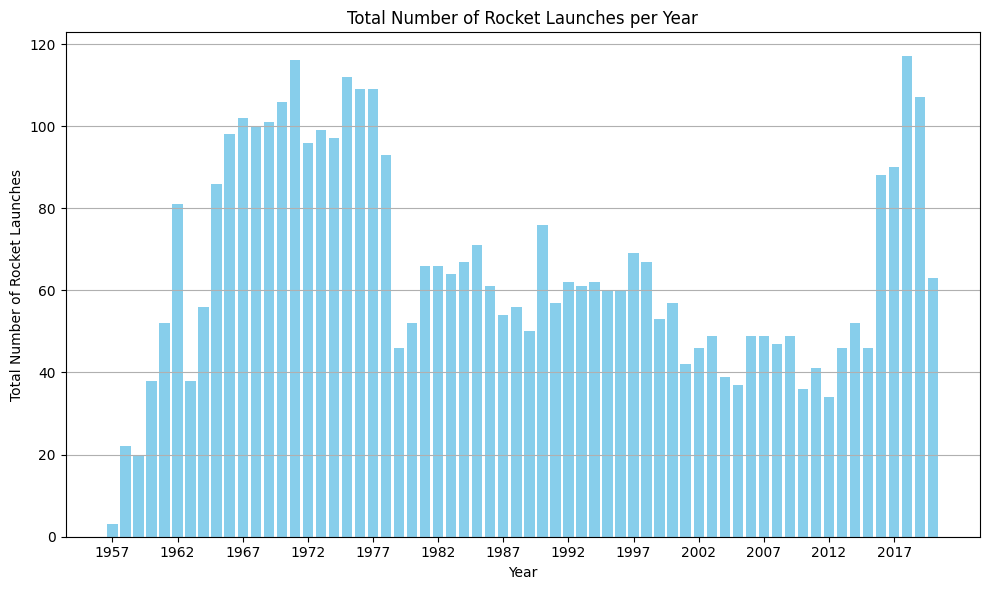

In [8]:
launch_counts = space_mission.groupby('year').size()

plt.figure(figsize=(10, 6))
plt.bar(launch_counts.index, launch_counts.values, color='skyblue')
plt.title('Total Number of Rocket Launches per Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Rocket Launches')
plt.xticks(launch_counts.index[::5])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

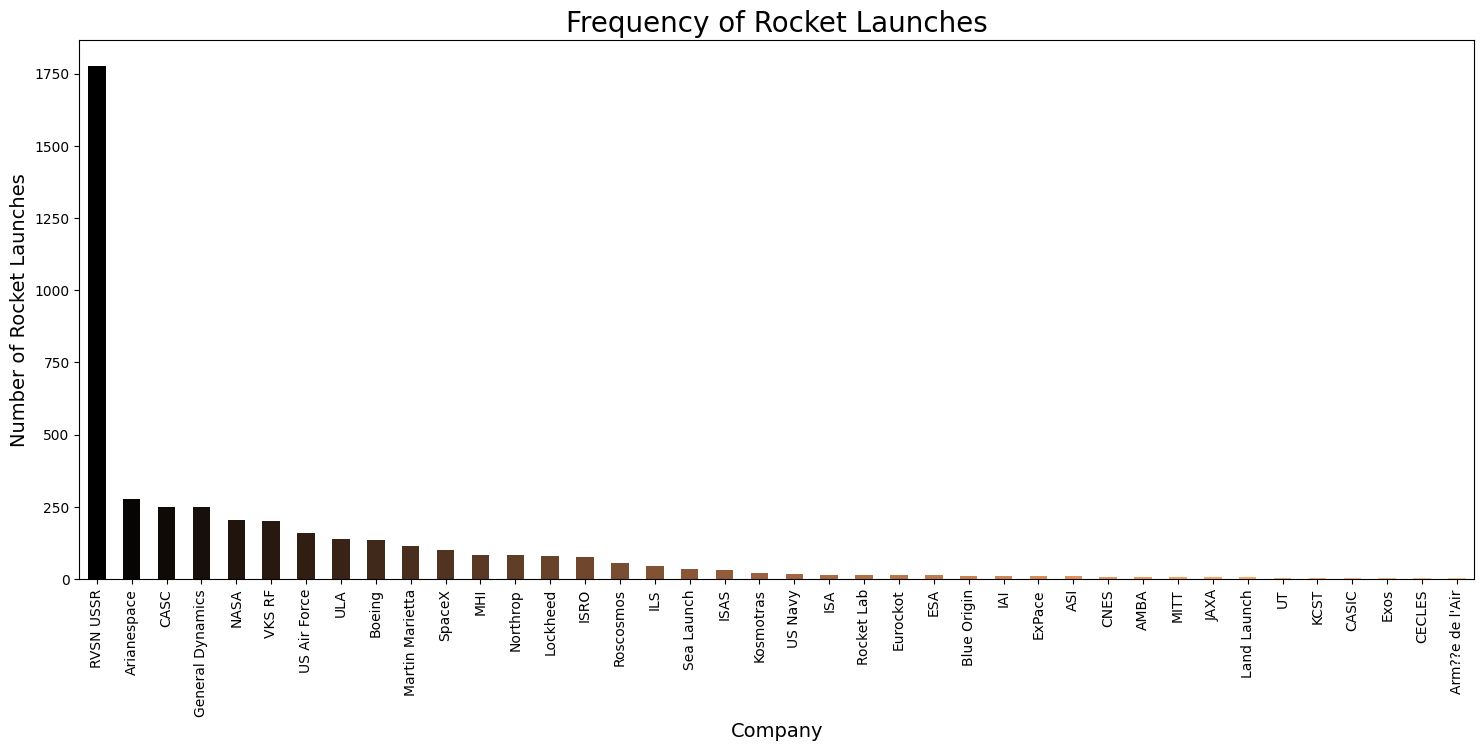

In [9]:
plt.rcParams['figure.figsize'] = (18, 7)

# Calculate the color gradient
color = plt.cm.copper(np.linspace(0, 1, 40))

# Count the frequency of rocket launches by each company
company_counts = space_mission['Company Name'].value_counts()

# Plotting
company_counts.head(40).plot.bar(color=color)
plt.title('Frequency of Rocket Launches', fontsize=20)
plt.xlabel('Company', fontsize=14)
plt.ylabel('Number of Rocket Launches', fontsize=14)
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

## 2.2 Cost

Cost as the year

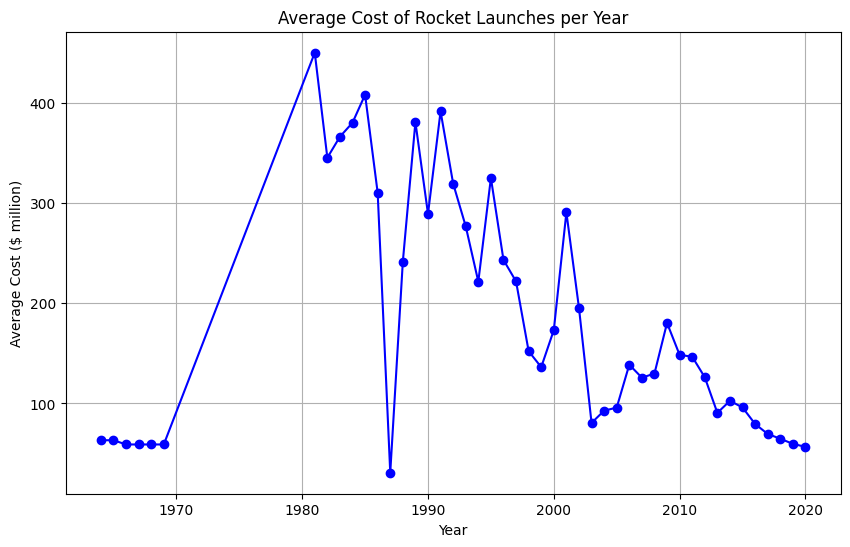

In [10]:
space_mission['Rocket'] = pd.to_numeric(space_mission['Rocket'], errors='coerce')

space_mission_cleaned = space_mission.dropna(subset=['Rocket'])

space_mission_cleaned['Datum'] = pd.to_datetime(space_mission_cleaned['Datum'])

space_mission_cleaned['Year'] = space_mission_cleaned['Datum'].dt.year

average_cost_per_year = space_mission_cleaned.groupby('Year')['Rocket'].mean()

plt.figure(figsize=(10, 6))
average_cost_per_year.plot(kind='line', marker='o', color='b', linestyle='-')
plt.title('Average Cost of Rocket Launches per Year')
plt.xlabel('Year')
plt.ylabel('Average Cost ($ million)')
plt.grid(True)
plt.show()

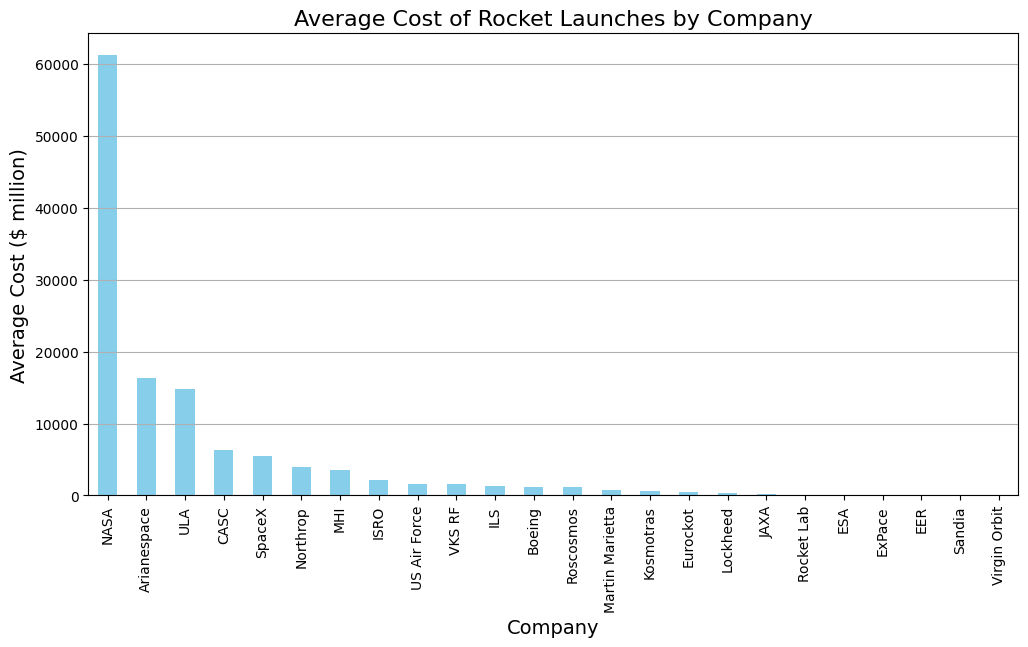

In [11]:
space_mission['Rocket'] = pd.to_numeric(space_mission['Rocket'], errors='coerce')

space_mission_cleaned = space_mission.dropna(subset=['Rocket'])

average_cost_by_company = space_mission_cleaned.groupby('Company Name')['Rocket'].sum()

plt.figure(figsize=(12, 6))
average_cost_by_company.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Average Cost of Rocket Launches by Company', fontsize=16)
plt.xlabel('Company', fontsize=14)
plt.ylabel('Average Cost ($ million)', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

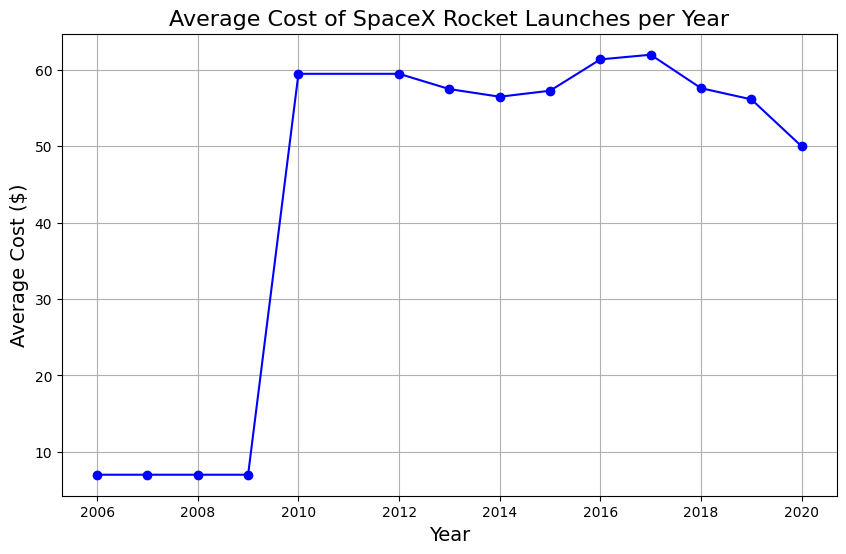

In [12]:
space_mission['Rocket'] = pd.to_numeric(space_mission['Rocket'], errors='coerce')

spacex_launches = space_mission[space_mission['Company Name'] == 'SpaceX']

spacex_launches_cleaned = spacex_launches.dropna(subset=['Rocket'])

spacex_launches_cleaned['Datum'] = pd.to_datetime(spacex_launches_cleaned['Datum'])

spacex_launches_cleaned['Year'] = spacex_launches_cleaned['Datum'].dt.year

average_cost_per_year = spacex_launches_cleaned.groupby('Year')['Rocket'].mean()

plt.figure(figsize=(10, 6))
average_cost_per_year.plot(kind='line', marker='o', color='b', linestyle='-')
plt.title('Average Cost of SpaceX Rocket Launches per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Cost ($)', fontsize=14)
plt.grid(True)
plt.show()

## 2.3 Success and failure

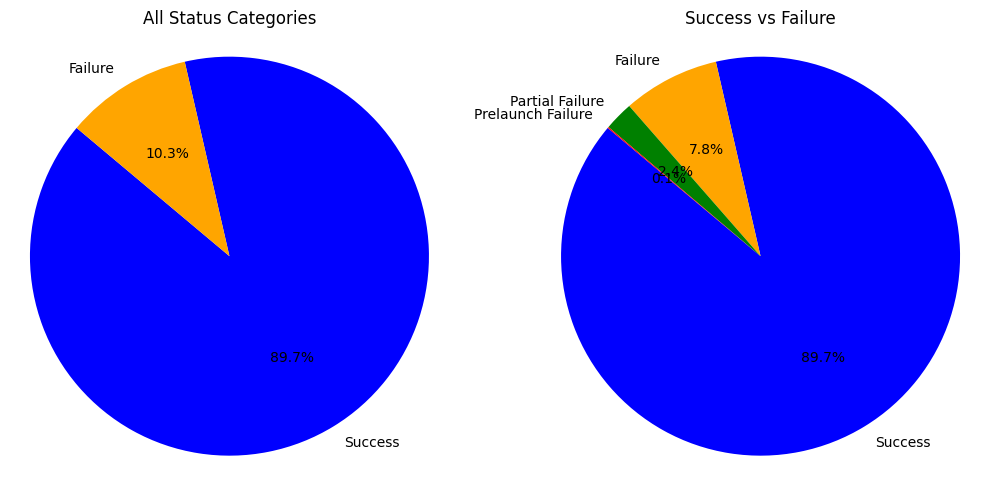

In [13]:
space_mission_cleaned = space_mission.dropna(subset=['Status Mission'])

success_failure = space_mission_cleaned[space_mission_cleaned['Status Mission'].str.contains('Success|Failure')]

space_mission_cleaned['Status Mission'] = space_mission_cleaned['Status Mission'].apply(lambda x: 'Failure' if 'Failure' in x else x)

status_counts_all = space_mission_cleaned['Status Mission'].value_counts()
status_counts_success_failure = success_failure['Status Mission'].value_counts()

colors_for_all_status = ['blue', 'orange', 'green', 'red', 'purple']  
colors_for_success_failure = ['green', 'red']  # Success in green, Failure in red

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(status_counts_all, labels=status_counts_all.index, autopct='%1.1f%%', startangle=140, colors=colors_for_all_status)
plt.title('All Status Categories')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.pie(status_counts_success_failure, labels=status_counts_success_failure.index, autopct='%1.1f%%', startangle=140, colors=colors_for_all_status)
plt.title('Success vs Failure')
plt.axis('equal')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

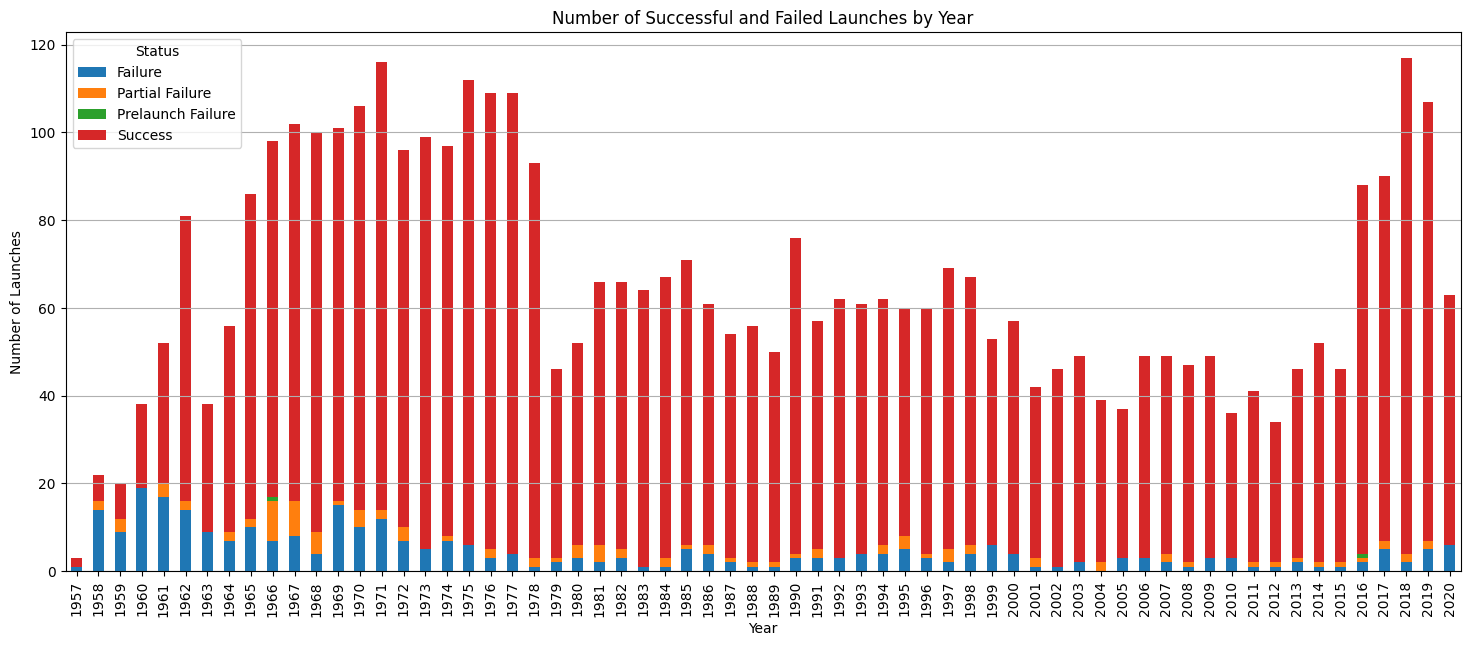

In [14]:
space_mission_cleaned = space_mission.dropna(subset=['Status Mission', 'Datum'])

success_failure = space_mission_cleaned[space_mission_cleaned['Status Mission'].str.contains('Success|Failure')]

success_failure['Datum'] = pd.to_datetime(success_failure['Datum'])

success_failure['Year'] = success_failure['Datum'].dt.year

status_counts_by_year = success_failure.groupby(['Year', 'Status Mission']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
status_counts_by_year.plot(kind='bar', stacked=True)
plt.title('Number of Successful and Failed Launches by Year')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.legend(title='Status')
plt.grid(axis='y')
plt.show()

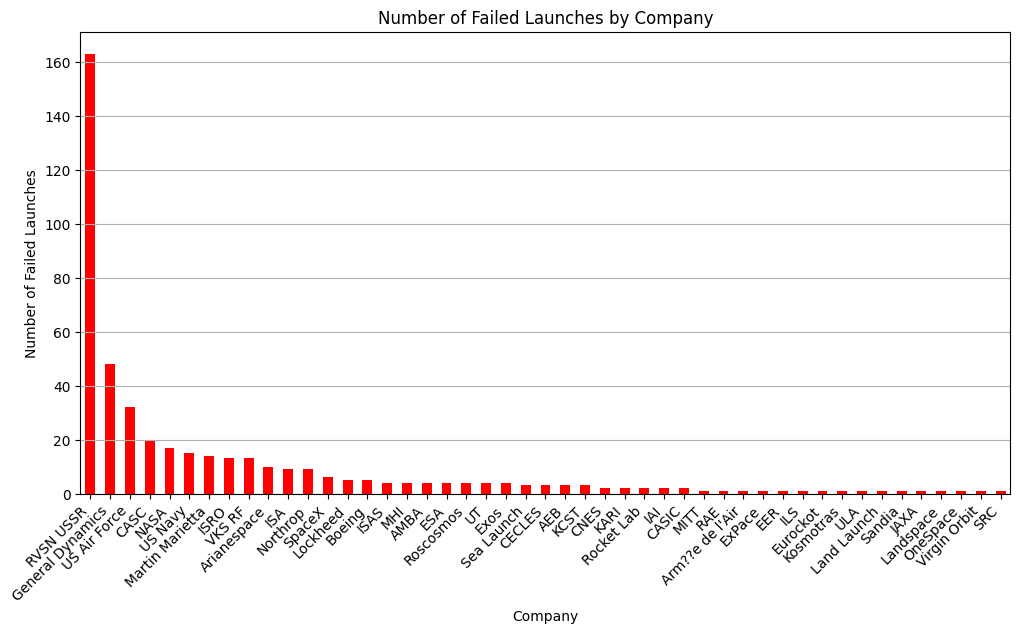

In [15]:
space_mission_cleaned = space_mission.dropna(subset=['Status Mission', 'Company Name'])

failed_missions = space_mission_cleaned[space_mission_cleaned['Status Mission'].str.contains('Failure|Prelaunch Failure|Partial Failure')]

failed_counts_by_company = failed_missions['Company Name'].value_counts()

# Plotting
plt.figure(figsize=(12, 6))
failed_counts_by_company.plot(kind='bar', color='red')
plt.title('Number of Failed Launches by Company')
plt.xlabel('Company')
plt.ylabel('Number of Failed Launches')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

<Figure size 1400x800 with 0 Axes>

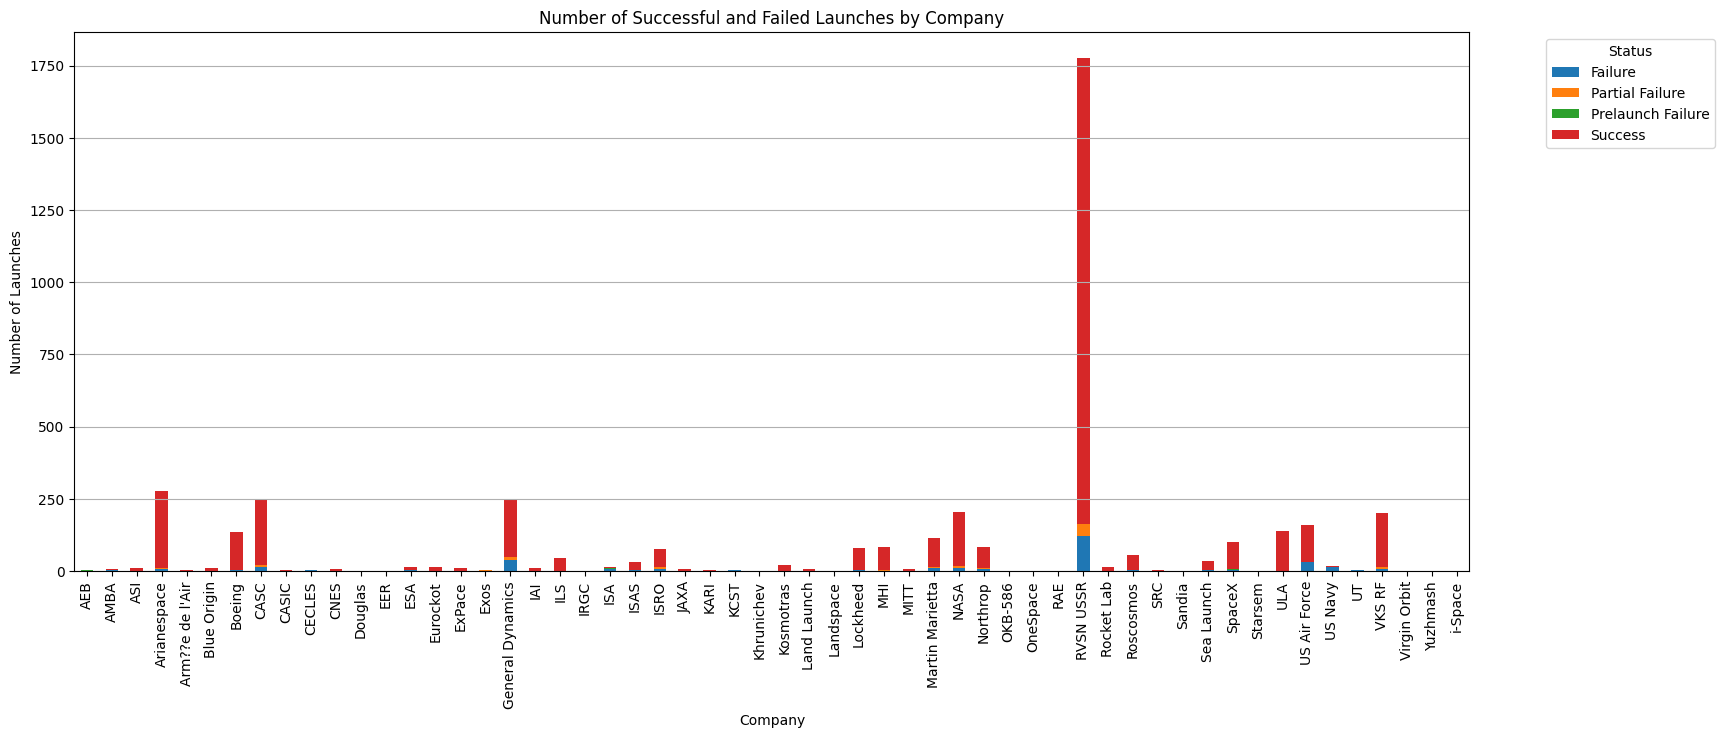

In [16]:
space_mission_cleaned = space_mission.dropna(subset=['Status Mission', 'Company Name'])

success_failure = space_mission_cleaned[space_mission_cleaned['Status Mission'].str.contains('Success|Failure')]

status_counts_by_year_company = success_failure.groupby(['Company Name', 'Status Mission']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
status_counts_by_year_company.plot(kind='bar', stacked=True)
plt.title('Number of Successful and Failed Launches by Company')
plt.xlabel('Company')
plt.ylabel('Number of Launches')
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

## 2.4 Failure findings

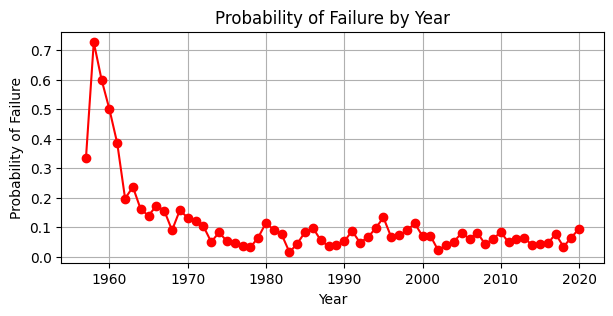

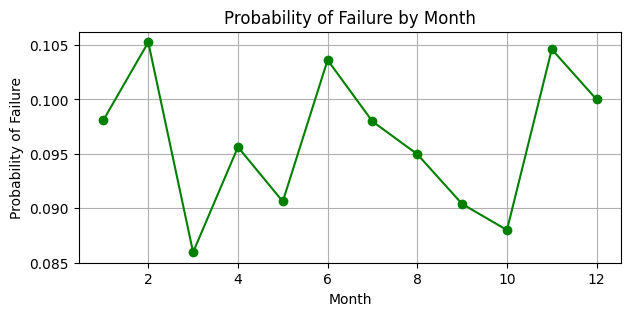

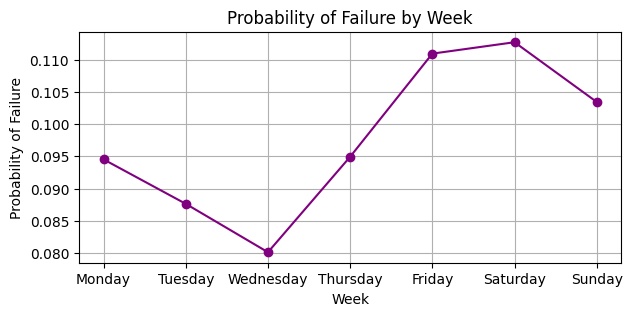

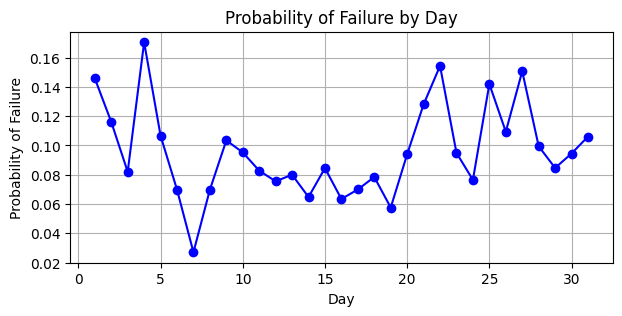

In [17]:
space_mission_cleaned = space_mission.dropna(subset=['Status Mission', 'Datum'])

failed_missions = space_mission_cleaned[space_mission_cleaned['Status Mission'].str.contains('Failure|Prelaunch Failure|Partial Failure')]

total_launches_by_year = space_mission_cleaned['Datum'].dt.year.value_counts().sort_index()
total_launches_by_month = space_mission_cleaned['Datum'].dt.month.value_counts().sort_index()
total_launches_by_day_of_week = space_mission_cleaned['Datum'].dt.dayofweek.value_counts().sort_index()
total_launches_by_day = space_mission_cleaned['Datum'].dt.day.value_counts().sort_index()

prob_failure_by_year = failed_missions['Datum'].dt.year.value_counts().sort_index() / total_launches_by_year
prob_failure_by_month = failed_missions['Datum'].dt.month.value_counts().sort_index() / total_launches_by_month
prob_failure_by_day_of_week = failed_missions['Datum'].dt.dayofweek.value_counts().sort_index() / total_launches_by_day_of_week
prob_failure_by_day = failed_missions['Datum'].dt.day.value_counts().sort_index() / total_launches_by_day

plt.figure(figsize=(7, 3))
plt.plot(prob_failure_by_year.index, prob_failure_by_year.values, color='red', marker='o', linestyle='-')
plt.title('Probability of Failure by Year')
plt.xlabel('Year')
plt.ylabel('Probability of Failure')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(prob_failure_by_month.index, prob_failure_by_month.values, color='green', marker='o', linestyle='-')
plt.title('Probability of Failure by Month')
plt.xlabel('Month')
plt.ylabel('Probability of Failure')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(prob_failure_by_day_of_week.index, prob_failure_by_day_of_week.values, color='purple', marker='o', linestyle='-')
plt.title('Probability of Failure by Week')
plt.xlabel('Week')
plt.ylabel('Probability of Failure')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(prob_failure_by_day.index, prob_failure_by_day.values, color='blue', marker='o', linestyle='-')
plt.title('Probability of Failure by Day')
plt.xlabel('Day')
plt.ylabel('Probability of Failure')
plt.grid(True)
plt.show()

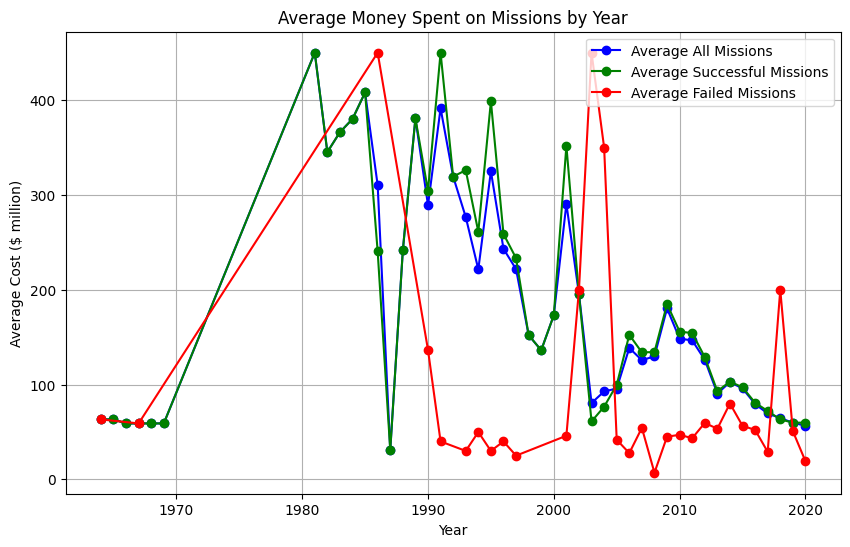

In [18]:
space_mission_cleaned = space_mission.dropna(subset=['Datum', 'Rocket'])
space_mission_cleaned = space_mission_cleaned[space_mission_cleaned['Rocket'] > 0]

space_mission_cleaned['Datum'] = pd.to_datetime(space_mission_cleaned['Datum'])

space_mission_cleaned['Year'] = space_mission_cleaned['Datum'].dt.year

average_money_by_year = space_mission_cleaned.groupby('Year')['Rocket'].mean()

successful_missions = space_mission_cleaned[space_mission_cleaned['Status Mission'] == 'Success']
average_money_successful_by_year = successful_missions.groupby('Year')['Rocket'].mean()

failed_missions = space_mission_cleaned[space_mission_cleaned['Status Mission'] != 'Success']
average_money_failed_by_year = failed_missions.groupby('Year')['Rocket'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_money_by_year.index, average_money_by_year.values, color='blue', marker='o', linestyle='-', label='Average All Missions')
plt.plot(average_money_successful_by_year.index, average_money_successful_by_year.values, color='green', marker='o', linestyle='-', label='Average Successful Missions')
plt.plot(average_money_failed_by_year.index, average_money_failed_by_year.values, color='red', marker='o', linestyle='-', label='Average Failed Missions')
plt.title('Average Money Spent on Missions by Year')
plt.xlabel('Year')
plt.ylabel('Average Cost ($ million)')
plt.legend()
plt.grid(True)
plt.show()

## 2.5 Model and classifier

RandomForestClassifier

In [19]:
space_mission_cleaned = space_mission.dropna(subset=['Company Name', 'Rocket', 'Country', 'Datum', 'Status Mission'])

le_company = LabelEncoder()
le_country = LabelEncoder()

space_mission_cleaned['Company Name'] = le_company.fit_transform(space_mission_cleaned['Company Name'])
space_mission_cleaned['Country'] = le_country.fit_transform(space_mission_cleaned['Country'])

space_mission_cleaned['Year'] = space_mission_cleaned['Datum'].dt.year
space_mission_cleaned['Month'] = space_mission_cleaned['Datum'].dt.month
space_mission_cleaned['Weekday'] = space_mission_cleaned['Datum'].dt.weekday
space_mission_cleaned['Day'] = space_mission_cleaned['Datum'].dt.day

X = space_mission_cleaned[['Company Name', 'Rocket', 'Country', 'Year', 'Month', 'Weekday', 'Day']]
y = space_mission_cleaned['Status Mission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.9735449735449735


SVM

In [20]:
X = space_mission_cleaned[['Company Name', 'Rocket', 'Country', 'Year', 'Month', 'Weekday', 'Day']]
y = space_mission_cleaned['Status Mission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9389920424403183
Testing Accuracy: 0.9735449735449735


## Correct dataset ##

In [21]:
space_data_sub = pd.read_csv('Space_Corrected.csv', encoding='latin-1')
invalid_data = space_data_sub[space_data_sub.apply(lambda x: x.astype(str).str.contains('\?')).any(axis=1)]
invalid_data[['Company Name', 'Location', 'Detail']]

# space_data_sub['Location'] = space_data_sub['Location'].str.replace(
#     ".*" + 'Rocket Lab LC-1A' + ".*",
#     "Rocket Lab LC-1A, Mahia Peninsula, New Zealand",
#     regex=True
# )

# space_data_sub['Location'] = space_data_sub['Location'].str.replace(
#     ".*" + 'VLS Pad' + ".*",
#     "VLS Pad, Alcântara Launch Center, Maranhao, Brazil",
#     regex=True
# )

# space_data_sub['Company Name'] = space_data_sub['Company Name'].str.replace(
#     ".*" + 'Arm' + ".*",
#     "Armee de l'Air",
#     regex=True
# )

# space_data_sub.to_csv('Space_Corrected_copy.csv', index=False)

Company Name                                          Location  \
15     Rocket Lab  Rocket Lab LC-1A, M?Âhia Peninsula, New Zealand   
21     Rocket Lab  Rocket Lab LC-1A, M?Âhia Peninsula, New Zealand   
46         VKS RF            Site 43/3, Plesetsk Cosmodrome, Russia   
55     Rocket Lab  Rocket Lab LC-1A, M?Âhia Peninsula, New Zealand   
60           CASC      LC-9, Taiyuan Satellite Launch Center, China   
...           ...                                               ...   
4266    RVSN USSR         Site 1/5, Baikonur Cosmodrome, Kazakhstan   
4286    RVSN USSR         Site 1/5, Baikonur Cosmodrome, Kazakhstan   
4295    RVSN USSR         Site 1/5, Baikonur Cosmodrome, Kazakhstan   
4298    RVSN USSR         Site 1/5, Baikonur Cosmodrome, Kazakhstan   
4301    RVSN USSR         Site 1/5, Baikonur Cosmodrome, Kazakhstan   

                                                Detail  
15        Electron/Curie | Pics Or It Didn??Â¦t Happen  
21                 Electron/Curie | Don't stop me now!  
46           Soyuz 2.1a/Fregat-M | Meridian-M nâ Â?9L  
55      Electron/Curie | Birds of a Feather / NROL-151  
60    Long March 2D | Jilin-1 Wideband 01 & ??uSat-7/8  
...                                                ...  
4266                      Vostok | E-3 nâ Â? (Luna-3)  
4286                     Vostok | E-1A nâ Â? (Luna-2)  
4295                      Vostok | E-1 nâ Â? (Luna-1)  
4298                      Vostok | E-1 nâ Â? (Luna-1)  
4301                      Vostok | E-1 nâ Â? (Luna-1)  

[350 rows x 3 columns]

## Map Visualization ##

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import zipfile
import os
import numpy as np

In [95]:
df = pd.read_csv('./astro_3.csv')
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Long, df.Lat), crs="EPSG:4326"
)

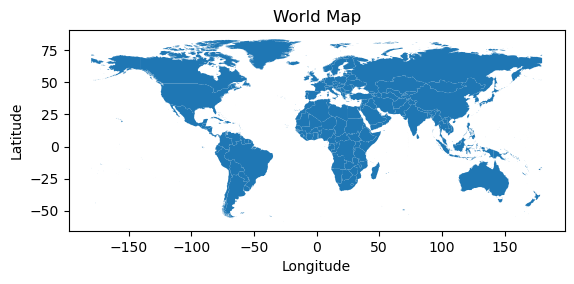

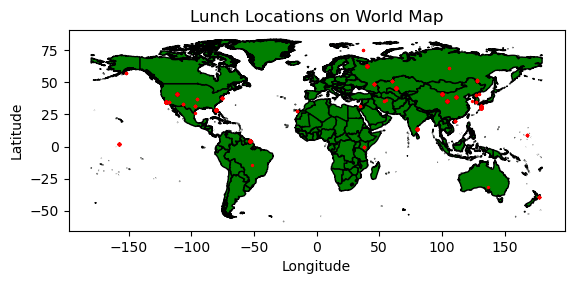

In [75]:
# Path to the world map shp file
dir = '/Users/maryam/Desktop/Data Mining/Project/world-administrative-boundaries'
world_map_shp = os.listdir(dir)
shp_file = [file for file in world_map_shp if file.endswith('.shp')]
world = gpd.read_file(os.path.join(dir, shp_file[0]))

# Plot the map
world.plot()
plt.title('World Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot the points from the DataFrame  
world.plot(color='green', edgecolor='black')
plt.scatter(df['Long'], df['Lat'], color='red', marker='o', s=2)  # Adjust marker size as needed

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Lunch Locations on World Map')
plt.show()



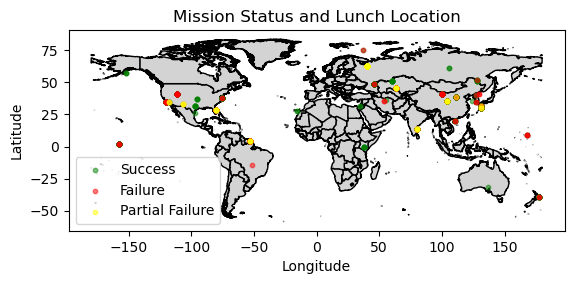

In [92]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# Path to the world map shp file
dir = '/Users/maryam/Desktop/Data Mining/Project/world-administrative-boundaries'
world_map_shp = os.listdir(dir)
shp_file = [file for file in world_map_shp if file.endswith('.shp')]
world = gpd.read_file(os.path.join(dir, shp_file[0]))

# Assuming df is your DataFrame containing partial failure data with columns 'Long', 'Lat', and 'Mission_Status'

# Plot the map
world.plot(color='lightgrey', edgecolor='black')
plt.title('World Map')

# Plot the points from the DataFrame
# Map mission status to colors
status_colors = {'Success': 'green', 'Failure': 'red', 'Partial Failure': 'yellow'}
for status, color in status_colors.items():
    subset = df[df['Mission Status'] == status]
    plt.scatter(subset['Long'], subset['Lat'], color=color, label=status, marker='o', s=10, alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mission Status and Lunch Location')
plt.legend()
plt.savefig('status_loc.png',dpi=1080)
plt.show()

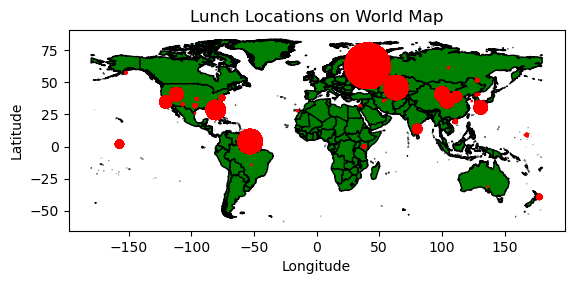

In [96]:
dir = '/Users/maryam/Desktop/Data Mining/Project/world-administrative-boundaries'
world_map_shp = os.listdir(dir)
shp_file = [file for file in world_map_shp if file.endswith('.shp')]
world = gpd.read_file(os.path.join(dir, shp_file[0]))

# Calculate density based on occurrence of longitude and latitude
density_df = df.groupby(['Long', 'Lat']).size().reset_index(name='Density')

# Merge density back to original DataFrame
df = pd.merge(df, density_df, on=['Long', 'Lat'])

# Plot the points from the df with marker size proportional to density
world.plot(color='green', edgecolor='black')
plt.scatter(df['Long'], df['Lat'], color='red', marker='o', s=df['Density'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Lunch Locations on World Map')
plt.savefig('lunch_loc.png',dpi=1080)
plt.show()

In [77]:
num_distinct_locations = df['Location'].nunique()

# Print the number of distinct locations
print("Number of distinct locations:", num_distinct_locations)

Number of distinct locations: 107


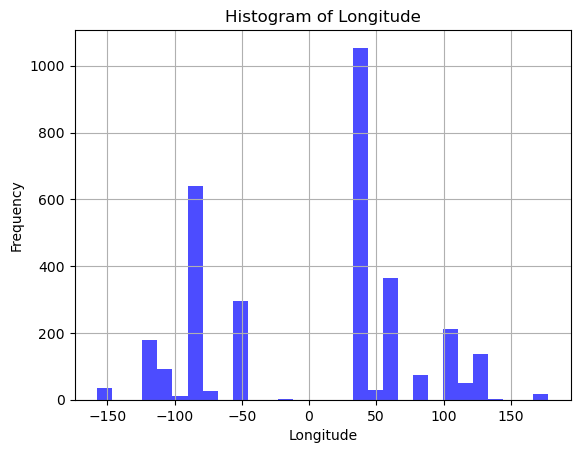

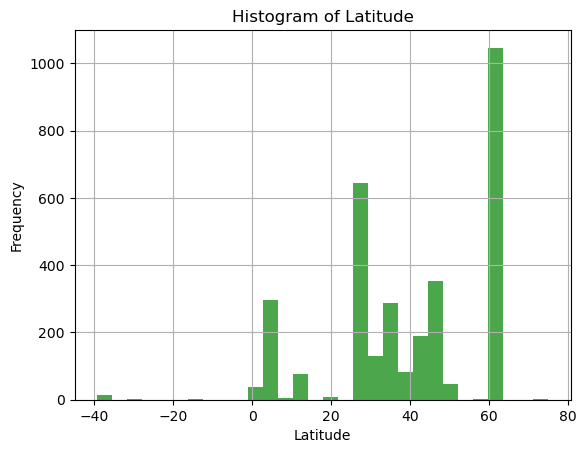

In [105]:

# Plot histogram for longitude
plt.hist(df['Long'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Longitude')
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('long.png',dpi=1080)
plt.show()

# Plot histogram for latitude
# plt.figure()
plt.hist(df['Lat'], bins=30, color='green', alpha=0.7)
plt.title('Histogram of Latitude')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('lat.png',dpi=1080)
plt.show()


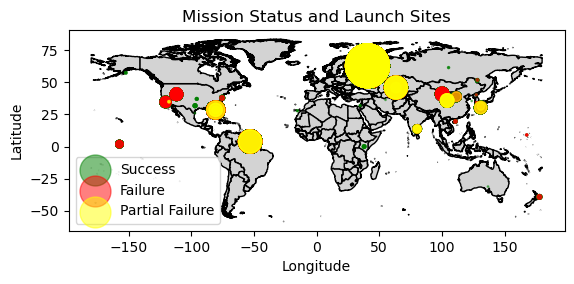

In [135]:
success_counts = df[df['Mission Status'] == 'Success'].groupby(['Long', 'Lat']).size().reset_index(name='Success_Count')

df = pd.merge(df, success_counts, on=['Long', 'Lat'], how='left', suffixes=('', '_success'))

df['Success_Count'] = df['Success_Count'].fillna(0)


world.plot(color='lightgrey', edgecolor='black')
plt.title('World Map')

status_colors = {'Success': 'green', 'Failure': 'red', 'Partial Failure': 'yellow'}
for status, color in status_colors.items():
    subset = df[df['Mission Status'] == status]
    plt.scatter(subset['Long'], subset['Lat'], color=color, label=status, marker='o', alpha=0.5, s=subset['Success_Count'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mission Status and Launch Sites')
plt.legend()
plt.savefig('stat.png',dpi=1080)
plt.show()
